# Figures for "Systematically comparing feature-based representations of intra-regional and inter-regional brain dynamics"

## Load python packages

In [1]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
from nilearn import plotting
from nilearn.image import math_img, resample_img, index_img, threshold_img
from matplotlib import pyplot as plt

%load_ext rpy2.ipython

## Load R Packages

In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(circlize)
    library(colorspace)
    library(ComplexHeatmap)
    library(correctR)
    library(cowplot)
    library(dendextend)
    library(factoextra)
    library(FactoMineR)
    library(ggnewscale)
    library(ggpp)
    library(ggpubr)
    library(ggraph)
    library(ggridges)
    library(ggseg)
    library(ggsegDefaultExtra)
    library(ggsegHO)
    library(ggsignif)
    library(glue)
    library(igraph)
    library(LaCroixColoR)
    library(patchwork)
    library(RColorBrewer)
    library(rlist)
    library(scales)
    library(see)
    library(splitstackshape)
    library(tidyverse)
    library(viridis)
})


# Set cowplot theme
theme_set(theme_cowplot())

## Load data needed for this analysis

In [3]:
# Load information about the time-series features
univariate_TS_feature_info = pd.read_csv("univariate_feature_info.csv")
pairwise_TS_feature_info = pd.read_csv("pairwise_feature_info.csv")

# Define SVM kernel type
SVM_kernel = "Linear"

# Name the feature sets
univariate_feature_set = "catch25"
pairwise_feature_set = "pyspi14"

# Load study metadata
data_path = "/Users/abry4213/data/"

# Load participants included
participants_in_project = pd.read_csv("data/participants_included_in_project.csv")
# UCLA_CNP_subjects_to_keep = pd.read_feather(f"{data_path}/UCLA_CNP/processed_data/UCLA_CNP_filtered_sample_info_AROMA_2P_GMR_catch25_pyspi14.feather")
# ABIDE_ASD_subjects_to_keep = pd.read_feather(f"{data_path}/ABIDE_ASD/processed_data/ABIDE_ASD_filtered_sample_info_FC1000_catch25_pyspi14.feather")

UCLA_CNP_metadata = (pd.read_feather("data/UCLA_CNP_sample_metadata.feather")
                        .assign(Study = "UCLA_CNP")
                        .query("Sample_ID in @participants_in_project.Sample_ID"))
ABIDE_ASD_metadata = (pd.read_feather("data/ABIDE_ASD_sample_metadata.feather")
                        .assign(Study = "ABIDE_ASD")
                        .query("Sample_ID in @participants_in_project.Sample_ID"))

# Load intra-regional time-series features per disorder
# TODO update with path once data is added to zenodo
UCLA_CNP_intra_regional_feature_data = (pd.read_feather(f"{data_path}/UCLA_CNP/processed_data/UCLA_CNP_AROMA_2P_GMR_catch25_filtered.feather")
                                        .merge(UCLA_CNP_metadata)
                                        .query("Sample_ID in @participants_in_project.Sample_ID"))
ABIDE_ASD_intra_regional_feature_data = (pd.read_feather(f"{data_path}/ABIDE_ASD/processed_data/ABIDE_ASD_FC1000_catch25_filtered.feather")
                                        .merge(ABIDE_ASD_metadata)
                                        .query("Sample_ID in @participants_in_project.Sample_ID"))

# Load balanced accuracy scores
intra_regional_balanced_accuracy_all_folds = (pd.read_feather("data/intra_regional_balanced_accuracy_all_folds.feather")
                                    .query("Univariate_Feature_Set == @univariate_feature_set & kernel == @SVM_kernel"))
inter_regional_balanced_accuracy_all_folds = (pd.read_feather("data/inter_regional_balanced_accuracy_all_folds.feather")
                                    .query("Pairwise_Feature_Set == @pairwise_feature_set"))
combined_balanced_accuracy_all_folds = (pd.read_feather("data/combined_balanced_accuracy_all_folds.feather")
                              .query("Univariate_Feature_Set == @univariate_feature_set & Pairwise_Feature_Set == @pairwise_feature_set")
                              .assign(Analysis_Type = "SPI_Univariate_Combo"))

balanced_accuracy_with_vs_without_inv_prob_weighting = (pd.read_feather("data/SVM_with_vs_without_inv_prob_weighting.feather"))
SVM_L1_balanced_accuracy_by_folds = (pd.read_feather("data/SVM_L1_Regularized_Balanced_Accuracy.feather"))
intra_regional_uni_combo_first25_PCs_balanced_accuracy = (pd.read_feather("data/combined_first25_PCs_balanced_accuracy.feather"))

# Load intra-regional null balanced accuracy
intra_regional_nulls = pd.read_feather("data/intra_regional_null_balanced_accuracy_distributions.feather")

# Load fold assignments
intra_regional_fold_assignments = pd.read_feather("data/intra_regional_fold_assignments.feather")



In [6]:
%%R -i intra_regional_balanced_accuracy_all_folds,inter_regional_balanced_accuracy_all_folds,combined_balanced_accuracy_all_folds -o UCLA_CNP_brain_region_info,ABIDE_ASD_brain_region_info,study_group_df,intra_regional_balanced_accuracy,inter_regional_balanced_accuracy,combined_balanced_accuracy,aparc_aseg_LUT

# Define study group dataframe
study_group_df <- data.frame(Study = c(rep("UCLA_CNP", 3), "ABIDE_ASD"),
                             Noise_Proc = c(rep("AROMA+2P+GMR",3), "FC1000"),
                             Comparison_Group = c("Schizophrenia", "Bipolar", "ADHD", "ASD"),
                             Group_Nickname = c("SCZ", "BP", "ADHD", "ASD"))

# Load brain region info
UCLA_CNP_brain_region_info <- read.csv("data/UCLA_CNP_Brain_Region_info.csv")
ABIDE_ASD_brain_region_info <- read.table("data/ABIDE_ASD_Brain_Region_info.txt", sep=";", header = T) %>%
  mutate(Brain_Region = ifelse(Index==45, "Heschl's Gyrus (includes H1 and H2)", Brain_Region))

aparc_aseg_LUT <- read.table("data/FreeSurferLUT.txt",
                             header=T) %>%
  dplyr::rename("ROI_Index" = "Value")

# Aggregate balanced accuracy results across folds
intra_regional_balanced_accuracy <- intra_regional_balanced_accuracy_all_folds %>%
  group_by(Study, Comparison_Group, Univariate_Feature_Set, Analysis_Type, group_var, kernel) %>%
  reframe(Balanced_Accuracy_Across_Folds = mean(Balanced_Accuracy, na.rm=T),
          Balanced_Accuracy_Across_Folds_SD = sd(Balanced_Accuracy, na.rm=T),
          Training_Balanced_Accuracy_Across_Folds = mean(Training_Balanced_Accuracy, na.rm=T))

inter_regional_balanced_accuracy <- inter_regional_balanced_accuracy_all_folds %>%
    group_by(Study, Comparison_Group, Pairwise_Feature_Set, Analysis_Type, group_var) %>%
    reframe(Balanced_Accuracy_Across_Folds = mean(Balanced_Accuracy, na.rm=T),
            Balanced_Accuracy_Across_Folds_SD = sd(Balanced_Accuracy, na.rm=T),
          Training_Balanced_Accuracy_Across_Folds = mean(Training_Balanced_Accuracy, na.rm=T))

combined_balanced_accuracy <- combined_balanced_accuracy_all_folds %>%
    group_by(Study, Comparison_Group, Univariate_Feature_Set, Pairwise_Feature_Set, Analysis_Type, group_var) %>%
    reframe(Balanced_Accuracy_Across_Folds = mean(Balanced_Accuracy, na.rm=T),
            Balanced_Accuracy_Across_Folds_SD = sd(Balanced_Accuracy, na.rm=T),
          Training_Balanced_Accuracy_Across_Folds = mean(Training_Balanced_Accuracy, na.rm=T))

In [7]:
# Load p-values
intra_regional_p_values = (pd.read_feather("data/intra_regional_empirical_p_values.feather")
                           .query("Univariate_Feature_Set == @univariate_feature_set")
                           .drop(columns=["Balanced_Accuracy_Across_Folds"])
                           .merge(intra_regional_balanced_accuracy))

inter_regional_p_values = (pd.read_feather("data/inter_regional_empirical_p_values.feather")
                            .query("Pairwise_Feature_Set == @pairwise_feature_set")
                            .drop(columns=["Balanced_Accuracy_Across_Folds"])
                            .merge(inter_regional_balanced_accuracy))

combined_p_values = (pd.read_feather("data/combined_empirical_p_values.feather")
                     .query("Univariate_Feature_Set == @univariate_feature_set & Pairwise_Feature_Set == @pairwise_feature_set")
                     .drop(columns=["Balanced_Accuracy_Across_Folds"])
                     .merge(combined_balanced_accuracy))


In [8]:
%%R 
# Source helper functions
source("data_visualisation/visualization_helper_functions.R")

# Figure 1: Methods

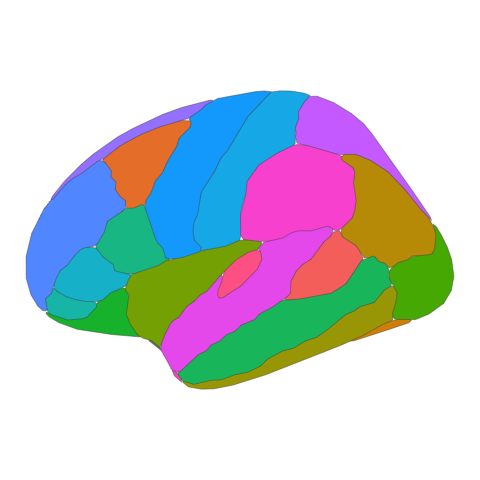

In [9]:
%%R

# Plot an example brain
ggplot() +
  geom_brain(atlas = dk, hemi="left", side="lateral", color="gray30") +
  theme_void() + 
  theme(legend.position="none")


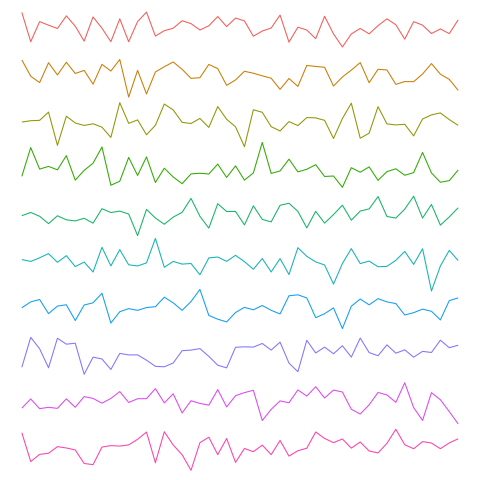

In [8]:
%%R 

# Plot a few example time-series
example_MTS <- as.data.frame(matrix(data=rnorm(500), nrow=50, ncol=10)) %>%
  mutate(Timepoint = 1:50) %>%
  pivot_longer(cols=c(-Timepoint), names_to = "Brain_Region", values_to="BOLD") %>%
  mutate(Brain_Region = as.factor(as.numeric(gsub("V", "", Brain_Region))))

example_MTS %>%
  ggplot(mapping=aes(x=Timepoint, y=BOLD, color=Brain_Region)) +
  geom_line() + 
  facet_grid(Brain_Region ~ .) +
  theme_void() +
  theme(legend.position = "none",
        strip.text = element_blank(),
        panel.spacing = unit(-1, "lines"))


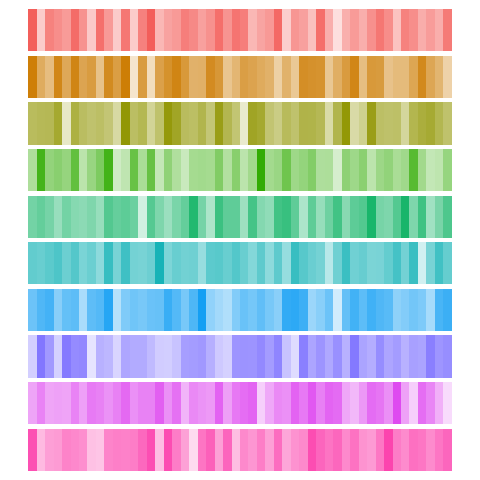

In [9]:
%%R

# Plot as an example MTS heatmap
gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

MTS_heatmap_list <- list()
MTS_colors <- gg_color_hue(10)
for (i in 1:length(unique(example_MTS$Brain_Region))) {
  roi = unique(example_MTS$Brain_Region)[i]
  roi_color = MTS_colors[i]
  roi_p <- example_MTS %>%
    filter(Brain_Region == roi) %>%
    ggplot(mapping=aes(x=Timepoint, fill=BOLD, y=0)) +
    geom_tile() + 
    theme_void() +
    scale_fill_gradient(low=alpha(roi_color, 0.2), high=roi_color) +
    theme(legend.position = "none")
  MTS_heatmap_list[[roi]] <- roi_p
}
wrap_plots(MTS_heatmap_list, ncol=1)


merging atlas and data by 'atlas', 'type', 'hemi', 'side', 'region', 'label', 'roi'


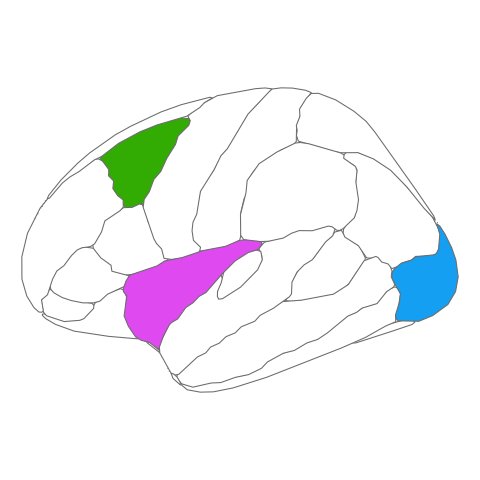

In [10]:
%%R
# Example brain with regions highlighted
dk %>%
  as_tibble() %>%
  mutate(fillval = case_when(label == "lh_caudalmiddlefrontal" ~ "1",
                             label == "lh_insula" ~ "2",
                             label == "lh_lateraloccipital" ~ "3", 
                             T ~ NA_character_)) %>%
  ggseg(atlas = "dk", mapping = aes(fill = fillval),
        hemisphere="left",
        view = "lateral",
        position = "stacked", colour = "gray50") +
  scale_fill_manual(values=c("#39b600", "#e76bf3", "#00b0f6"),
                    na.value="white") +
  theme_void() +
  theme(plot.title = element_blank(),
        legend.position = "none")


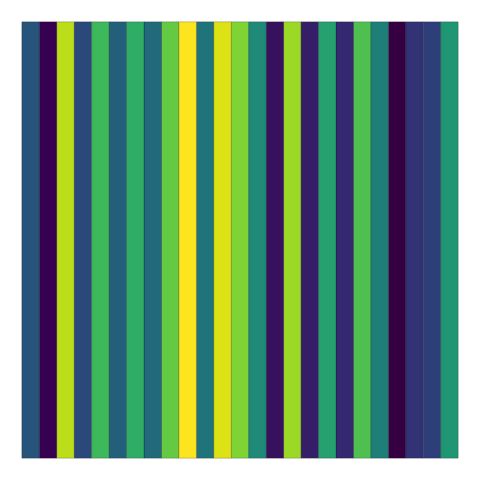

In [13]:
%%R
# Sample feature vector
data.frame(x=sample(1:25),
           y=as.character(1:25)) %>%
  ggplot(data=., mapping=aes(x=x, y=0, fill=y)) +
  geom_tile(color="black") +
  scale_fill_viridis_d() +
  theme_void() +
  theme(legend.position = "none")

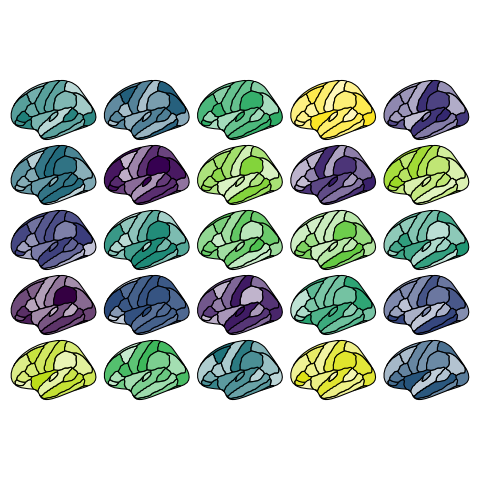

In [17]:
%%R

# Brains with all 25 features [simulated data]
brain_colors <- viridis::viridis(25)

plots <- sample(1:25) %>%
  purrr::map(~ suppressMessages(plot_feature_in_brain(fill_color_gradient=brain_colors[.x], 
                                                      region_label="all")))
wrap_plots(plots, nrow=5)

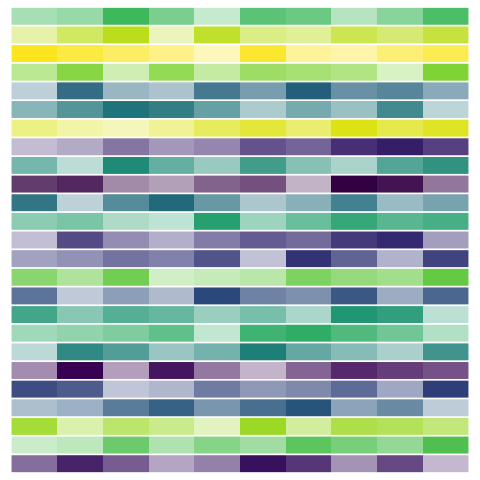

In [20]:
%%R

# Plot feature X region matrix
feature_vec_plot_list <- list()
for (i in sample(1:25)) {
  p <- suppressWarnings(data.frame(x=sample(1:10),
             y=as.character(1:10)) %>%
    ggplot(data=., mapping=aes(x=y, y=0, fill=x)) +
    geom_raster(color="black") +
    scale_fill_gradientn(colors=c(alpha(brain_colors[i], 0.3), 
                                  brain_colors[i]), 
                         na.value=NA) +
    theme_void() +
    theme(legend.position = "none"))
  feature_vec_plot_list <- list.append(feature_vec_plot_list, p)
}

wrap_plots(feature_vec_plot_list, ncol=1)

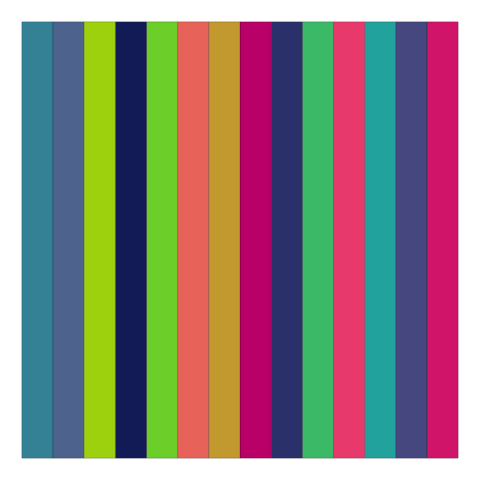

In [21]:
%%R
# Sample pairwise feature vector
pyspi_colors <- unname(lacroix_palette("PassionFruit",14))
data.frame(x=sample(1:14),
           y=as.character(1:14)) %>%
  ggplot(data=., mapping=aes(x=x, y=0, fill=y)) +
  geom_tile(color="black") +
  scale_fill_manual(values=pyspi_colors) +
  theme_void() +
  theme(legend.position = "none")

R[write to console]: In addition: 
R[write to console]: There were 13 warnings (use warnings() to see them)
R[write to console]: 



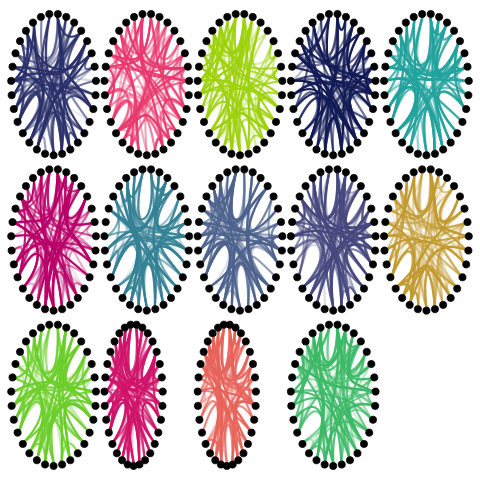

In [31]:
%%R

# Example network graph
set.seed(127)

# Data for all pairwise connection graphs
# Edges are defined as cortical lobe --> specific ROI connection
edges <- read.csv("region_node_hierarchy.csv") %>% distinct()
# ROIs don't include the origin --> cortical lobe connection
rois <- edges %>% filter(!(to %in% c("Cingulate", "Frontal", "Insula",
                                     "Occipital", "Parietal", "Temporal")))
# Create a dataframe of vertices, one line per object in the ROI cortical lobe hierarchy
vertices = data.frame(name = unique(c(as.character(edges$from), as.character(edges$to))))
vertices$group <- edges$from[match(vertices$name, edges$to)]
# Create an igraph object
mygraph <- graph_from_data_frame(edges, vertices=vertices)

# plot_network_data is defined in visualization_helper_functions.R
plots <- sample(1:14) %>%
  purrr::map(~ plot_network_data(pyspi_colors[.x]))
wrap_plots(plots, nrow=3)


# Figure 2: Local properties of BOLD dynamics in individual brain regions can meaningfully distinguish cases versus controls

merging atlas and data by 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'
merging atlas and data by 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'
merging atlas and data by 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'


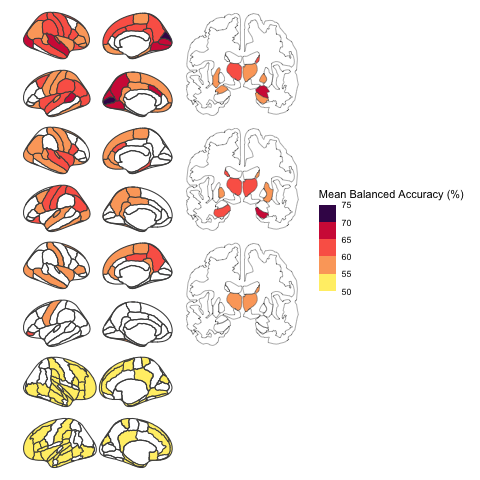

In [35]:
%%R -i intra_regional_p_values -o significant_univariate_region_wise_results

# Define dataset with univariate region-wise results
significant_univariate_region_wise_results <- intra_regional_p_values %>%
  filter(Analysis_Type == "Univariate_Brain_Region") %>%
  filter(p_value_HolmBonferroni < 0.05) %>%
  mutate(Balanced_Accuracy_Across_Folds = 100*Balanced_Accuracy_Across_Folds)

catch25_region_wise_balacc_plot_list <- suppressMessages(plot_balacc_in_brain(significant_univariate_region_wise_results,
                                                             bin_seq_range=seq(50,75,by=5)))
wrap_plots(catch25_region_wise_balacc_plot_list, 
           ncol=2, 
           byrow=T) + 
  plot_layout(guides = "collect")

In [39]:
# We can get the number of significant regions per disorder
significant_univariate_region_wise_results['Comparison_Group'].value_counts()

Comparison_Group
Schizophrenia    65
Bipolar          45
ASD              28
ADHD             18
Name: count, dtype: int64

# Figure 3: Analysis with individual time-series features measured across the brain highlights diverse differences in brain-wide dynamics across clinical groups

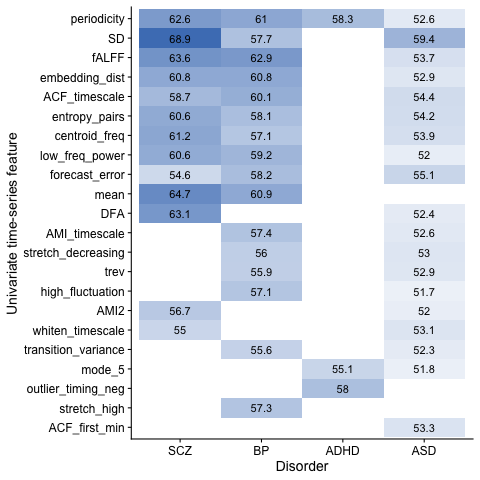

In [44]:
%%R -i intra_regional_p_values,univariate_TS_feature_info,univariate_feature_set

# Balanced accuracy heatmap
intra_regional_p_values %>%
  filter(Univariate_Feature_Set == univariate_feature_set,
         Analysis_Type == "Univariate_TS_Feature") %>%
  dplyr::rename("feature_name" = "group_var") %>%
  left_join(., univariate_TS_feature_info, by="feature_name") %>%
  filter(p_value_HolmBonferroni<0.05) %>%
  mutate(Comparison_Group = case_when(Comparison_Group == "Schizophrenia" ~ "SCZ",
                                      Comparison_Group == "Bipolar" ~ "BP",
                                      T ~ Comparison_Group),
         Balanced_Accuracy_Across_Folds = 100*Balanced_Accuracy_Across_Folds) %>%
  mutate(Figure_name = fct_reorder(Figure_name, Balanced_Accuracy_Across_Folds, .fun=sum),
         Comparison_Group = factor(Comparison_Group, levels = c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ggplot(data=., mapping=aes(x=Comparison_Group, y=Figure_name, 
                             fill=Balanced_Accuracy_Across_Folds)) +
  geom_tile()+
  geom_text(aes(label = round(Balanced_Accuracy_Across_Folds, 1))) +
  scale_fill_gradientn(colors=c(alpha("#4C7FC0", 0.1), "#4C7FC0"), 
                       na.value=NA) +
  labs(fill = "Mean Balanced Accuracy (%)") +
  xlab("Disorder") +
  ylab("Univariate time-series feature") +
  theme(legend.position="none",
        strip.background = element_blank(),
        strip.text = element_blank())

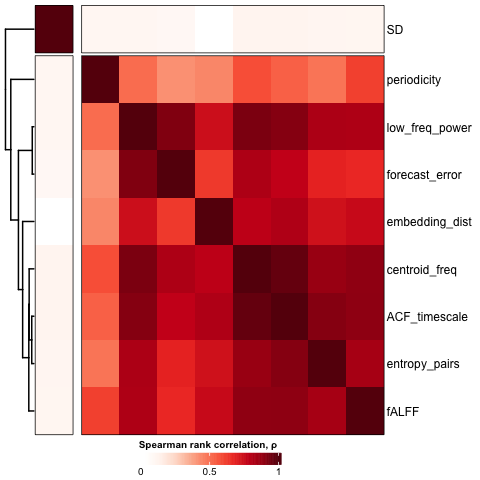

In [52]:
%%R -i intra_regional_p_values,univariate_TS_feature_info,univariate_feature_set,UCLA_CNP_intra_regional_feature_data,ABIDE_ASD_intra_regional_feature_data

# Create adjacency matrix of feature values across all participants
top_features <- intra_regional_p_values %>%
  filter(Univariate_Feature_Set == univariate_feature_set,
         Analysis_Type == "Univariate_TS_Feature") %>%
  group_by(group_var) %>%
  filter(sum(p_value_HolmBonferroni<0.05)>=3) %>%
  summarise(sum_balacc = sum(Balanced_Accuracy_Across_Folds)) %>%
  slice_max(sum_balacc, n=10) %>%
  pull(group_var)

# Calculate the absolute Spearman correlation between each pair of features
data_for_corr_heatmap <- plyr::rbind.fill(UCLA_CNP_intra_regional_feature_data, ABIDE_ASD_intra_regional_feature_data) %>%
  filter(names %in% top_features) %>%
  mutate(unique_ID = paste0(Sample_ID, "__", Brain_Region), .keep="unused") %>%
  left_join(., univariate_TS_feature_info, by=c("names"="feature_name")) %>%
  dplyr::select(unique_ID, Figure_name, values) %>%
  pivot_wider(id_cols=unique_ID, names_from=Figure_name, values_from=values) %>%
  dplyr::select(-unique_ID) %>%
  cor(method="spearman", use="complete.obs") %>%
  abs()

# Convert to long for easy querying
data_for_corr_long <- data_for_corr_heatmap %>%
  as.data.frame() %>%
  rownames_to_column(var="feature1") %>%
  pivot_longer(cols=c(-feature1), names_to="feature2", values_to="spearman_corr_abs")

# Define two branches for the dendrogram
num_branches <- 2

# Draw the heatmap
ht1 <- ComplexHeatmap::Heatmap(data_for_corr_heatmap,
                               clustering_distance_rows = "spearman",
                               clustering_distance_columns = "spearman",
                               clustering_method_rows = "average",
                               clustering_method_columns = "average",
                               row_names_side = "right",
                               row_dend_side = "left", 
                               row_dend_width = unit(1, "cm"),
                               row_dend_gp = gpar(lwd=unit(2, "cm")),
                               row_split = num_branches,
                               column_split = num_branches,
                               column_gap = unit(3, "mm"),
                               row_title = NULL,
                               column_title = NULL,
                               show_row_names = TRUE,
                               show_column_names = FALSE,
                               show_column_dend = FALSE,
                               border = TRUE,
                               col = c("white", brewer.pal(9, "Reds")),
                               name = "Spearman rank correlation, \u03c1",
                               heatmap_legend_param = list(legend_direction = "horizontal",
                                                           legend_width = unit(5, "cm")))

suppressWarnings(draw(ht1, heatmap_legend_side = "bottom",
                      background = "transparent"))

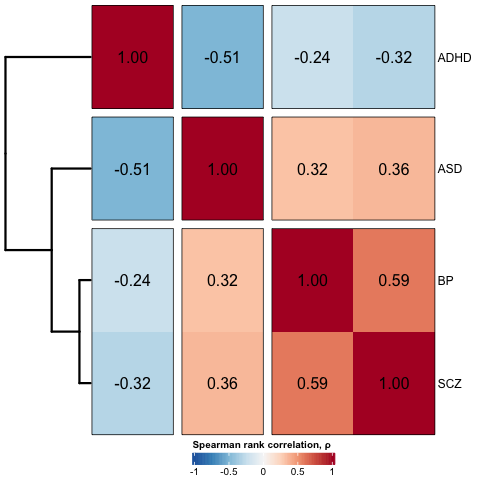

In [53]:
%%R -i intra_regional_p_values,study_group_df

# How are different disorders correlated in terms of classification accuracy by univariate intra-regional time-series feature?

feature_accuracy_corr_data <- intra_regional_p_values %>%
  filter(Analysis_Type=="Univariate_TS_Feature") %>%
  left_join(., study_group_df, by = join_by(Study, Comparison_Group)) %>%
  dplyr::select(group_var, Group_Nickname, Balanced_Accuracy_Across_Folds) %>%
  pivot_wider(id_cols=group_var, names_from=Group_Nickname, values_from=Balanced_Accuracy_Across_Folds) %>%
  dplyr::select(-group_var) %>%
  cor(method="spearman")

num_branches <- 3
ht2 <- ComplexHeatmap::Heatmap(feature_accuracy_corr_data,
                               clustering_distance_rows = "spearman",
                               clustering_distance_columns = "spearman",
                               clustering_method_rows = "average",
                               clustering_method_columns = "average",
                               row_names_side = "right",
                               row_dend_side = "left", 
                               row_dend_width = unit(3, "cm"),
                               row_dend_gp = gpar(lwd=unit(3, "cm")),
                               row_split = num_branches,
                               row_gap = unit(3, "mm"),
                               column_split = num_branches,
                               column_gap = unit(3, "mm"),
                               row_title = NULL,
                               column_title = NULL,
                               show_row_names = TRUE,
                               show_column_names = FALSE,
                               show_column_dend = FALSE,
                               border = TRUE,
                               cell_fun = function(j, i, x, y, width, height, fill) {
                                 grid.text(sprintf("%.2f", feature_accuracy_corr_data[i, j]), x, y, gp = gpar(fontsize = 16))
                               },
                               col = colorRamp2(seq(-1, 1, length.out=9), brewer_pal("div", "RdBu", direction=-1)(9)),
                               name = "Spearman rank correlation, \u03c1",
                               heatmap_legend_param = list(legend_direction = "horizontal",
                                                           legend_width = unit(5, "cm")))

suppressWarnings(draw(ht2, heatmap_legend_side = "bottom",
                      background = "transparent"))

# Figure 4: Representing a multivariate fMRI time series with whole-brain maps of univariate features improves classification performance for BP, but not for SCZ, ADHD, or ASD—for which simpler representations are better suited

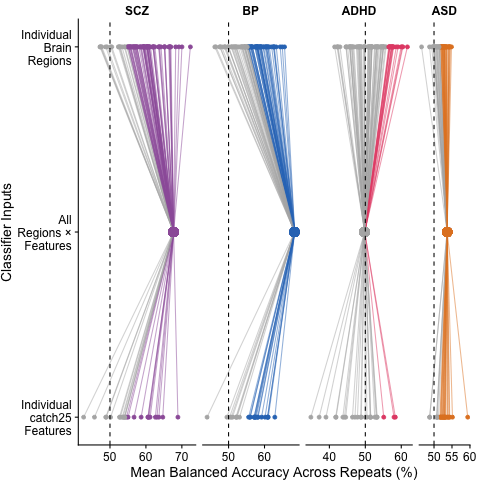

In [55]:
%%R -i intra_regional_p_values

# BOWTIE PLOT 

# Summarise performance metrics
intra_regional_p_values %>%
  filter(Analysis_Type == "Univariate_Combo") %>% 
  mutate(summarymean = round(Balanced_Accuracy_Across_Folds*100,1),
         summarysd = round(Balanced_Accuracy_Across_Folds_SD*100,1)) %>%
  dplyr::select(Comparison_Group, summarymean, summarysd) %>%
  arrange(desc(summarymean))

# Bowtie plot comparing each brain region and feature to combo-wise performance
num_comparisons <- intra_regional_p_values %>%
  filter(Analysis_Type != "Univariate_Combo") %>%
  group_by(Study, Comparison_Group) %>%
  count()

intra_regional_p_values %>%
  filter(Analysis_Type == "Univariate_Combo") %>% 
  left_join(., num_comparisons, by = join_by(Study, Comparison_Group)) %>%
  expandRows("n") %>%
  group_by(Study, Comparison_Group) %>%
  mutate(group_ID = paste0(Comparison_Group, "_", row_number())) %>%
  plyr::rbind.fill(., intra_regional_p_values %>%
                     filter(Analysis_Type != "Univariate_Combo") %>%
                     group_by(Study, Comparison_Group) %>%
                     mutate(group_ID = paste0(Comparison_Group, "_", row_number()))) %>%
  rowwise() %>%
  mutate(Comparison_Group = case_when(Comparison_Group == "Schizophrenia" ~ "SCZ",
                                      Comparison_Group == "Bipolar" ~ "BP",
                                      T ~ Comparison_Group),
         Analysis_Label = case_when(Analysis_Type == "Univariate_Combo" ~ "All\nRegions \u00D7\nFeatures",
                                    Analysis_Type == "Univariate_TS_Feature" ~ "Individual\ncatch25\nFeatures",
                                    T ~ "Individual\nBrain\nRegions"),
         Analysis_Sig = paste0(Comparison_Group, "_", p_value_HolmBonferroni < 0.05)) %>%
  mutate(Comparison_Group = factor(Comparison_Group, levels = c("SCZ", "BP", "ADHD", "ASD")),
         Analysis_Label = factor(Analysis_Label, levels = c("Individual\ncatch25\nFeatures",
                                                            "All\nRegions \u00D7\nFeatures",
                                                            "Individual\nBrain\nRegions"))) %>%
  group_by(Study, Comparison_Group, group_ID) %>%
  mutate(Comparison_Sig = paste0(Comparison_Group, "_", p_value_HolmBonferroni[Analysis_Type != "Univariate_Combo"]<0.05)) %>% 
  ggplot(data=., mapping=aes(x=Analysis_Label, y=100*Balanced_Accuracy_Across_Folds, 
                             group=group_ID, color=Comparison_Sig)) +
  geom_line(alpha=0.5) +
  geom_point(aes(size=Analysis_Type, color=Analysis_Sig)) +
  ylab("Mean Balanced Accuracy Across Repeats (%)") +
  xlab("Classifier Inputs") +
  geom_hline(yintercept = 50, linetype=2) +
  scale_x_discrete(expand=c(0.05,0.05,0.05,0.05)) +
  scale_size_manual(values=c("Univariate_Combo"=4,
                             "Univariate_TS_Feature"=1.5,
                             "Univariate_Brain_Region" = 1.5)) +
  scale_color_manual(values = c("SCZ_TRUE"="#9d60a8", 
                                "BP_TRUE"="#2F77C0", 
                                "ADHD_TRUE"="#e45075",
                                "ASD_TRUE"="#E28328",
                                "SCZ_FALSE"="gray70", 
                                "BP_FALSE"="gray70", 
                                "ADHD_FALSE"="gray70",
                                "ASD_FALSE"="gray70")) +
  facet_grid(. ~ Comparison_Group, scales="free_x", space="free") +
  theme(legend.position = "none",
        plot.margin = margin(1,10,1,1),
        strip.background = element_blank(),
        strip.text = element_text(face="bold")) + 
  coord_flip()

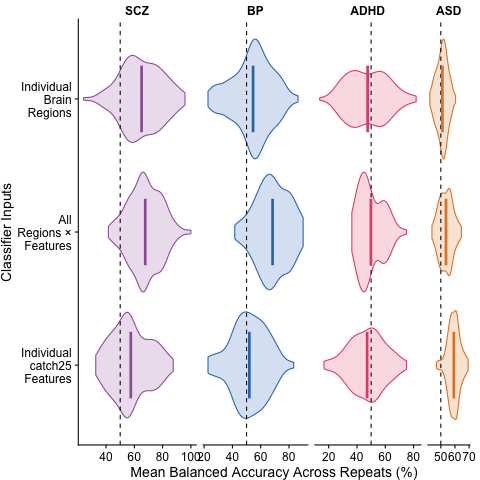

In [56]:
%%R -i intra_regional_balanced_accuracy_all_folds -o intra_regional_balanced_accuracy_best_from_in_sample

# Take only the top-performing region and time-series feature from training data folds
intra_regional_balanced_accuracy_best_from_in_sample_all_folds <- intra_regional_balanced_accuracy_all_folds %>%
  group_by(Study, Comparison_Group, Univariate_Feature_Set, Analysis_Type, Fold, Repeat_Number) %>%
  filter(Training_Balanced_Accuracy==max(Training_Balanced_Accuracy)) %>%
  ungroup() %>%
  group_by(Study, Comparison_Group, Univariate_Feature_Set, Analysis_Type) %>%
  mutate(Mean_CV_Balanced_Accuracy_Overall = mean(Balanced_Accuracy),
         SD_Balanced_Accuracy_Overall = sd(Balanced_Accuracy)) 
intra_regional_balanced_accuracy_best_from_in_sample <- intra_regional_balanced_accuracy_best_from_in_sample_all_folds %>%
  group_by(Study, Comparison_Group, Univariate_Feature_Set, Analysis_Type, group_var, Mean_CV_Balanced_Accuracy_Overall) %>%
  reframe(percent_of_100 = n()/100)

# Violin plot
intra_regional_balanced_accuracy_best_from_in_sample_all_folds %>%
  mutate(Comparison_Group = case_when(Comparison_Group == "Schizophrenia" ~ "SCZ",
                                      Comparison_Group == "Bipolar" ~ "BP",
                                      T ~ Comparison_Group),
         Analysis_Label = case_when(Analysis_Type == "Univariate_Combo" ~ "All\nRegions \u00D7\nFeatures",
                                    Analysis_Type == "Univariate_TS_Feature" ~ "Individual\ncatch25\nFeatures",
                                    T ~ "Individual\nBrain\nRegions")) %>%
  mutate(Comparison_Group = factor(Comparison_Group, levels = c("SCZ", "BP", "ADHD", "ASD")),
         Analysis_Label = factor(Analysis_Label, levels = c("Individual\ncatch25\nFeatures",
                                                            "All\nRegions \u00D7\nFeatures",
                                                            "Individual\nBrain\nRegions"))) %>%
  ggplot(data=., mapping=aes(x=Analysis_Label, y=100*Balanced_Accuracy, 
                             fill=Comparison_Group, color = Comparison_Group)) +
  geom_violin(alpha=0.2) +
  facet_grid(. ~ Comparison_Group, scales="free", space="free") +
  ylab("Mean Balanced Accuracy Across Repeats (%)") +
  xlab("Classifier Inputs") +
  geom_hline(yintercept = 50, linetype=2) +
  stat_summary(fun = "mean",
               geom = "crossbar", 
               width = 0.5) +
  scale_fill_manual(values = c("SCZ"="#9d60a8", 
                                "BP"="#2F77C0", 
                                "ADHD"="#e45075",
                                "ASD"="#E28328")) +
  scale_color_manual(values = c("SCZ"="#9d60a8", 
                                "BP"="#2F77C0", 
                                "ADHD"="#e45075",
                                "ASD"="#E28328")) +
  theme(legend.position = "none",
        plot.margin = margin(1,10,1,1),
        strip.background = element_blank(),
        strip.text = element_text(face="bold")) + 
  coord_flip()

In [57]:
%%R -i intra_regional_balanced_accuracy_best_from_in_sample,univariate_TS_feature_info

# What are the top-performing regions and features in general by disorder?

intra_regional_balanced_accuracy_best_from_in_sample %>%
  group_by(Comparison_Group, Analysis_Type) %>%
  top_n(n=1, wt=percent_of_100) %>%
  left_join(., univariate_TS_feature_info, by=c("group_var"="feature_name")) %>%
  dplyr::select(Comparison_Group, Analysis_Type, group_var, Figure_name, percent_of_100)

# A tibble: 12 × 5
# Groups:   Comparison_Group, Analysis_Type [12]
   Comparison_Group Analysis_Type           group_var Figure_name percent_of_100
   <chr>            <chr>                   <chr>     <chr>                <dbl>
 1 ASD              Univariate_Brain_Region Parahipp… <NA>                  0.19
 2 ASD              Univariate_Combo        Combo     <NA>                  1   
 3 ASD              Univariate_TS_Feature   DN_Sprea… SD                    0.99
 4 ADHD             Univariate_Brain_Region ctx-rh-p… <NA>                  0.22
 5 ADHD             Univariate_Combo        Combo     <NA>                  1   
 6 ADHD             Univariate_TS_Feature   SC_Fluct… rs_range              0.63
 7 Bipolar          Univariate_Brain_Region Right-Hi… <NA>                  0.34
 8 Bipolar          Univariate_Combo        Combo     <NA>                  1   
 9 Bipolar          Univariate_TS_Feature   PD_Perio… periodicity           0.56
10 Schizophrenia    Univariate_Brain_Regi

# Figure 5: Representing brain activity as the set of all pairwise functional connectivity strengths, $\mathrm{A_{FC}}$, can significantly distinguish cases from controls—with the classical Pearson correlation coefficient as a top performer.

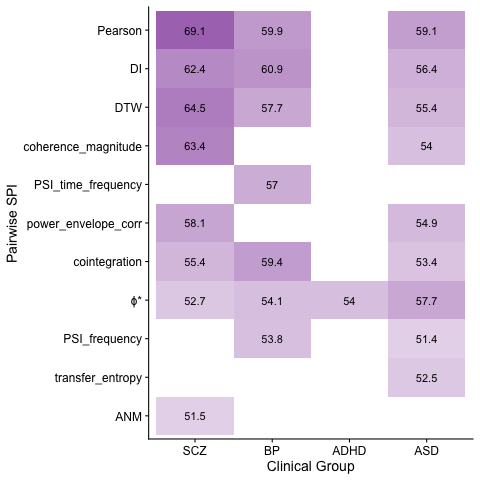

In [59]:
%%R -i inter_regional_p_values,pairwise_feature_set,pairwise_TS_feature_info

# Balanced accuracy heatmap

inter_regional_p_values %>%
  filter(Pairwise_Feature_Set == pairwise_feature_set,
         Analysis_Type == "Pairwise_SPI",
         p_value_HolmBonferroni < 0.05) %>%
  dplyr::rename("pyspi_name" = "group_var") %>%
  left_join(., pairwise_TS_feature_info, by = join_by(pyspi_name)) %>%
  # Rename phi-star
  mutate(Figure_name = case_when(Figure_name == "phi_star" ~ "\u03D5*",
                                T ~ Figure_name)) %>%
  mutate(Comparison_Group = case_when(Comparison_Group == "Schizophrenia" ~ "SCZ",
                                      Comparison_Group == "Bipolar" ~ "BP",
                                      T ~ Comparison_Group),
         Balanced_Accuracy_Across_Folds = 100*Balanced_Accuracy_Across_Folds) %>%
  mutate(Figure_name = fct_reorder(Figure_name, Balanced_Accuracy_Across_Folds, .fun=mean),
         Comparison_Group = factor(Comparison_Group, levels = c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ggplot(data=., mapping=aes(x=Comparison_Group, y=Figure_name, 
                             fill=Balanced_Accuracy_Across_Folds)) +
  geom_tile()+
  geom_text(aes(label = round(Balanced_Accuracy_Across_Folds, 1))) +
  scale_fill_gradientn(colors=c(alpha("#AC77BD", 0.3), "#AC77BD"), 
                       na.value=NA)  + 
  scale_y_discrete(labels = wrap_format(28)) +
  labs(fill = "Mean Balanced Accuracy (%)") +
  xlab("Clinical Group") +
  ylab("Pairwise SPI") +
  theme(legend.position="none")

In [65]:
# Create correlogram for top 10 SPIs if data file does not already exist
UCLA_CNP_pyspi14 = (pd.read_feather(f"{data_path}/UCLA_CNP/processed_data/UCLA_CNP_AROMA_2P_GMR_pyspi14_filtered.feather")
                    .merge(UCLA_CNP_metadata))
ABIDE_ASD_pyspi14 = (pd.read_feather(f"{data_path}/ABIDE_ASD/processed_data/ABIDE_ASD_FC1000_pyspi14_filtered.feather")
                    .merge(ABIDE_ASD_metadata))
    

In [ ]:
%%R -i UCLA_CNP_pyspi14,ABIDE_ASD_pyspi14,pairwise_TS_feature_info,inter_regional_p_values -o data_for_corr_long

if (!(file.exists("data/SPI_performance_correlation_across_disorders.csv"))) {
  # Correlogram by SPI for 10 SPIs with significant balanced accuracies
  merged_pyspi14 <- plyr::rbind.fill(UCLA_CNP_pyspi14, ABIDE_ASD_pyspi14) %>%
    mutate(unique_ID = paste0(Sample_ID, "__", brain_region_from, "__", brain_region_to), .keep="unused") 

  # Create adjacency matrix of feature values across all participants
  unique_groups <- unique(merged_pyspi14$SPI)
  group_combinations <- combn(unique_groups, 2, simplify = FALSE)

  cor_list <- list()

  for (i in 1:length(group_combinations)) {
    group_pair <- sort(group_combinations[[i]])
    
    SPI1 <- group_pair[1]
    SPI2 <- group_pair[2]
    
    SPI1_data <- merged_pyspi14 %>% filter(SPI==SPI1) %>% pull(value)
    SPI2_data <- merged_pyspi14 %>% filter(SPI==SPI2) %>% pull(value)
    
    correlation_df <- data.frame(SPI1 = SPI1,
                                  SPI2 = SPI2,
                                  SPI1_nickname = SPI1_nickname,
                                  SPI2_nickname = SPI2_nickname,
                                  spearman_corr_abs = abs(cor(SPI1_data, SPI2_data, method = "spearman",  use="complete.obs")))
    
    cor_list <- list.append(cor_list, correlation_df)
    
    rm(SPI1_data)
    rm(SPI2_data)
    gc()
  }

  data_for_corr_long <- do.call(plyr::rbind.fill, cor_list)

  write.table(data_for_corr_long, "data/SPI_performance_correlation_across_disorders.csv", sep=",", row.names=F)
}


In [68]:
# can clear these objects from memory at this point
del UCLA_CNP_pyspi14, ABIDE_ASD_pyspi14

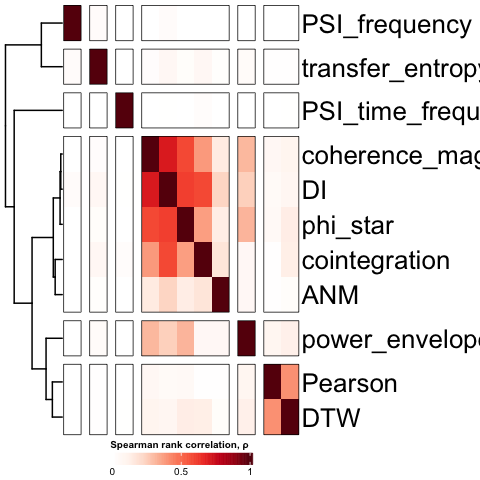

In [67]:
%%R -i inter_regional_p_values,pairwise_feature_set,pairwise_TS_feature_info

# Read in SPI correlation data
data_for_corr_long <- read.table("data/SPI_performance_correlation_across_disorders.csv", sep=",", header=T)

sig_SPIs <- inter_regional_p_values %>%
  filter(Pairwise_Feature_Set == pairwise_feature_set,
         Analysis_Type == "Pairwise_SPI",
         p_value_HolmBonferroni < 0.05) %>%
  distinct(group_var) %>%
  dplyr::rename("pyspi_name" = "group_var") %>%
  left_join(., pairwise_TS_feature_info, by = join_by(pyspi_name)) %>%
  pull(Figure_name)

# Convert to long for easy querying
data_for_corr_heatmap <- data_for_corr_long %>%
  plyr::rbind.fill(., data_for_corr_long %>% rename("SPI1_nickname"="SPI2_nickname", "SPI2_nickname"="SPI1_nickname")) %>%
  pivot_wider(id_cols=SPI1_nickname, names_from=SPI2_nickname, values_from=spearman_corr_abs) %>%
  column_to_rownames(var="SPI1_nickname") %>%
  select(all_of(sig_SPIs)) %>%
  dplyr::filter(row.names(.) %in% sig_SPIs) %>%
  as.matrix()
data_for_corr_heatmap[is.na(data_for_corr_heatmap)] <- 1

# Rearrange rows and columns
data_for_corr_heatmap <- data_for_corr_heatmap[sig_SPIs, sig_SPIs]

# Use six branches
num_branches <- 6

ht1 <- ComplexHeatmap::Heatmap(data_for_corr_heatmap,
                               clustering_distance_rows = "spearman",
                               clustering_distance_columns = "spearman",
                               clustering_method_rows = "average",
                               clustering_method_columns = "average",
                               row_names_side = "right",
                               row_dend_side = "left", 
                               row_dend_width = unit(2, "cm"),
                               row_dend_gp = gpar(lwd=unit(2, "cm")),
                               row_split = num_branches,
                               row_gap = unit(3, "mm"),
                               column_split = num_branches,
                               column_gap = unit(3, "mm"),
                               row_title = NULL,
                               column_title = NULL,
                               show_row_names = TRUE,
                               row_names_gp = grid::gpar(fontsize = 26),
                               show_column_names = FALSE,
                               show_column_dend = FALSE,
                               border = TRUE,
                               col = c("white", brewer.pal(9, "Reds")),
                               name = "Spearman rank correlation, \u03c1",
                               heatmap_legend_param = list(legend_direction = "horizontal",
                                                           legend_width = unit(5, "cm")))

suppressWarnings(draw(ht1, heatmap_legend_side = "bottom",
                      background = "transparent"))

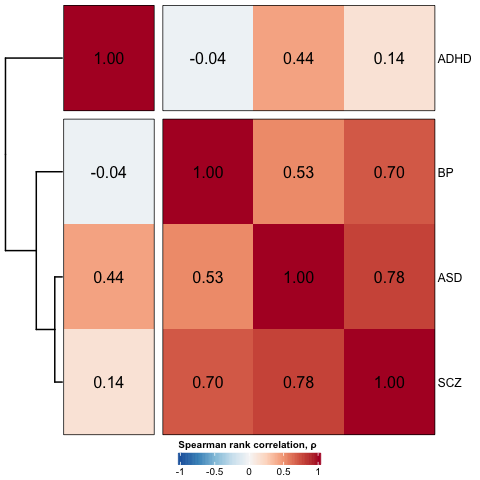

In [72]:
%%R -i inter_regional_p_values,study_group_df

# How are different disorders correlated in terms of classification accuracy by pairwise SPI?

SPI_accuracy_corr_data <- inter_regional_p_values %>%
  left_join(., study_group_df, by = join_by(Study, Comparison_Group)) %>%
  dplyr::select(group_var, Group_Nickname, Balanced_Accuracy_Across_Folds) %>%
  pivot_wider(id_cols=group_var, names_from=Group_Nickname, values_from=Balanced_Accuracy_Across_Folds) %>%
  dplyr::select(-group_var) %>%
  cor(method="spearman")

num_branches <- 2
ht2 <- ComplexHeatmap::Heatmap(SPI_accuracy_corr_data,
                               clustering_distance_rows = "spearman",
                               clustering_distance_columns = "spearman",
                               clustering_method_rows = "average",
                               clustering_method_columns = "average",
                               row_names_side = "right",
                               row_dend_side = "left", 
                               row_dend_width = unit(2, "cm"),
                               row_dend_gp = gpar(lwd=unit(2, "cm")),
                               row_split = num_branches,
                               row_gap = unit(3, "mm"),
                               column_split = num_branches,
                               column_gap = unit(3, "mm"),
                               row_title = NULL,
                               column_title = NULL,
                               show_row_names = TRUE,
                               show_column_names = FALSE,
                               show_column_dend = FALSE,
                               border = TRUE,
                               cell_fun = function(j, i, x, y, width, height, fill) {
                                 grid.text(sprintf("%.2f", SPI_accuracy_corr_data[i, j]), x, y, gp = gpar(fontsize = 16))
                               },
                               col = colorRamp2(seq(-1, 1, length.out=9), brewer_pal("div", "RdBu", direction=-1)(9)),
                               name = "Spearman rank correlation, \u03c1",
                               heatmap_legend_param = list(legend_direction = "horizontal",
                                                           legend_width = unit(5, "cm")))


suppressWarnings(draw(ht2, heatmap_legend_side = "bottom",
                      background = "transparent"))

# Figure 6: Adding local regional dynamics enhances classification performance for many pairwise FC metrics.

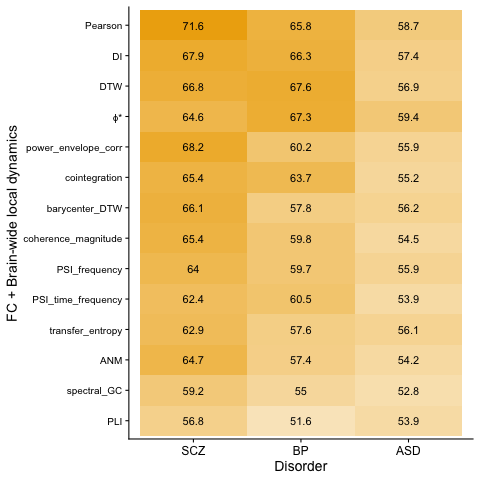

In [74]:
%%R -i combined_p_values,pairwise_feature_set,pairwise_TS_feature_info

# Heatmap for balanced accuracy values
combined_p_values %>%
  filter(Pairwise_Feature_Set == pairwise_feature_set,
         Analysis_Type == "SPI_Univariate_Combo",
         p_value_HolmBonferroni < 0.05) %>%
  dplyr::rename("pyspi_name" = "group_var") %>%
  left_join(., pairwise_TS_feature_info, by = join_by(pyspi_name)) %>%
  mutate(Comparison_Group = case_when(Comparison_Group == "Schizophrenia" ~ "SCZ",
                                      Comparison_Group == "Bipolar" ~ "BP",
                                      T ~ Comparison_Group),
         Balanced_Accuracy_Across_Folds = 100*Balanced_Accuracy_Across_Folds) %>%
  # Rename phi-star
  mutate(Figure_name = case_when(Figure_name == "phi_star" ~ "\u03D5*",
                                T ~ Figure_name)) %>%
  mutate(Figure_name = fct_reorder(Figure_name, Balanced_Accuracy_Across_Folds, .fun=mean),
         Comparison_Group = factor(Comparison_Group, levels = c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ggplot(data=., mapping=aes(x=Comparison_Group, y=Figure_name, 
                             fill=Balanced_Accuracy_Across_Folds)) +
  geom_tile()+
  geom_text(aes(label = round(Balanced_Accuracy_Across_Folds, 1))) +
  scale_fill_gradientn(colors=c(alpha("darkgoldenrod2", 0.3), "darkgoldenrod2"), 
                       na.value=NA)  + 
  scale_y_discrete(labels = wrap_format(28)) +
  labs(fill = "Mean Balanced Accuracy (%)") +
  xlab("Disorder") +
  ylab("FC + Brain-wide local dynamics") +
  theme(legend.position="none",
        axis.text.y = element_text(size=10))

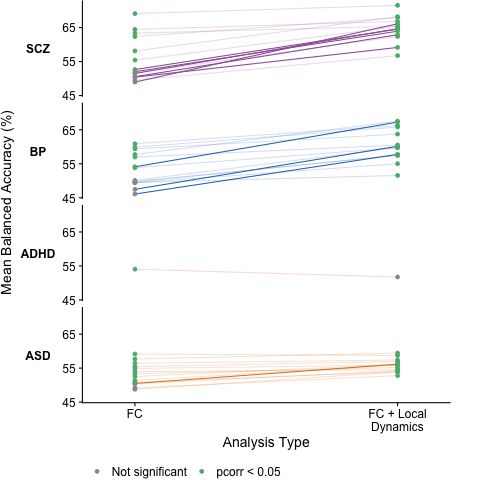

In [76]:
%%R -i inter_regional_balanced_accuracy_all_folds,inter_regional_p_values,combined_balanced_accuracy_all_folds,combined_p_values,study_group_df,UCLA_CNP_metadata,ABIDE_ASD_metadata,pairwise_TS_feature_info

results_df = plyr::rbind.fill(inter_regional_balanced_accuracy_all_folds %>% left_join(inter_regional_p_values %>%
                                                                                       dplyr::select(Study:group_var, p_value_HolmBonferroni), 
                                                                                       by = join_by(group_var, Analysis_Type, Comparison_Group, Study, Pairwise_Feature_Set)), 
                              combined_balanced_accuracy_all_folds %>% left_join(combined_p_values %>%
                                                                                 dplyr::select(Study:group_var, p_value_HolmBonferroni), 
                                                                                 by = join_by(group_var, Analysis_Type, Comparison_Group, Study, Pairwise_Feature_Set)))

corrected_SPI_T_res <- 1:nrow(study_group_df) %>%
  purrr::map_df(~ run_correctR_group(comparison_group = study_group_df$Comparison_Group[.x],
                                     study = study_group_df$Study[.x],
                                     metadata = plyr::rbind.fill(UCLA_CNP_metadata, ABIDE_ASD_metadata),
                                     results_df = results_df)) %>%
  left_join(., pairwise_TS_feature_info, by=c("SPI"="pyspi_name"))

plyr::rbind.fill(inter_regional_p_values,
                 combined_p_values) %>%
  dplyr::rename("SPI" = group_var) %>%
  semi_join(., corrected_SPI_T_res %>% dplyr::select(SPI, Comparison_Group), by = join_by(Comparison_Group, SPI)) %>%
  left_join(., corrected_SPI_T_res, by = join_by(Comparison_Group, SPI)) %>%
  mutate(Analysis_Type = ifelse(Analysis_Type == "Pairwise_SPI", "FC", "FC + Local\nDynamics"),
         individually_significant = ifelse(p_value_HolmBonferroni < 0.05, "pcorr < 0.05", "Not significant"),
         significant_diff_with_univariate = ifelse(p_value_corr_HolmBonferroni < 0.05, "Sig Diff", "No Sig Diff"),
         Analysis_Type = factor(Analysis_Type, levels=c("FC", "FC + Local\nDynamics")),
         Comparison_Group = case_when(Comparison_Group == "Schizophrenia" ~ "SCZ",
                                      Comparison_Group == "Bipolar" ~ "BP",
                                      T ~ Comparison_Group)) %>%
  mutate(Comparison_Group = factor(Comparison_Group, levels = c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ggplot(data=., mapping=aes(x=Analysis_Type, y=100*Balanced_Accuracy_Across_Folds,
                             group = SPI)) +
  geom_line(aes(color = Comparison_Group, 
                alpha = significant_diff_with_univariate), show.legend = FALSE) +
  scale_alpha_manual(values=c("Sig Diff" = 1, "No Sig Diff" = 0.2)) +
  scale_color_manual(values=c("Control" = "#5BB67B", 
                              "SCZ" = "#9d60a8", 
                              "BP" = "#2F77C0", 
                              "ADHD" = "#e45075", 
                              "ASD" = "#E28328")) +
  facet_wrap(Comparison_Group ~ ., ncol=1, scales="fixed", strip.position = "left") +
  new_scale_colour() +  # start a new scale
  geom_point(aes(color = individually_significant)) +
  scale_color_manual(values = c("gray60", "#5BB67B")) +
  # scale_x_discrete(labels = wrap_format(7)) +
  xlab("Analysis Type") +
  ylab("Mean Balanced Accuracy (%)") +
  scale_y_continuous(breaks=c(45, 55, 65)) +
  scale_x_discrete(expand=c(0,0.2,0,0.2)) +
  theme(legend.position = "bottom",
        strip.placement = "outside",
        strip.background = element_blank(),
        strip.text.y.left = element_text(angle=0, face="bold"),
        plot.margin = margin(1,30,1,1, unit="pt"),
        legend.title = element_blank())

# Figure 7: Comparing case–control classification across fMRI activity representations by neuropsychiatric disorder

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Groups with fewer than two data points have been dropped. 

R[write to console]: 2: Groups with fewer than two data points have been dropped. 

R[write to console]: 3: Groups with fewer than two data points have been dropped. 

R[write to console]: 4: Groups with fewer than two data points have been dropped. 



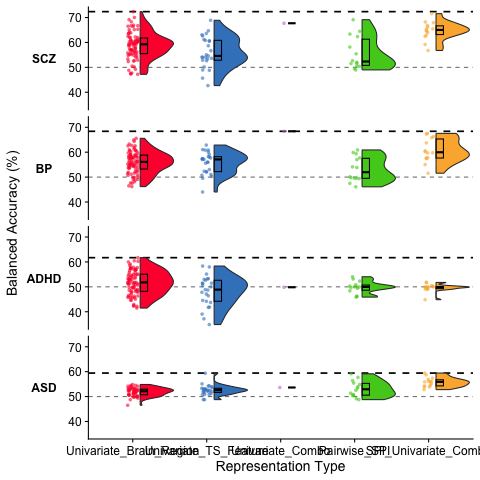

In [78]:
%%R -i intra_regional_p_values,inter_regional_p_values,combined_p_values,intra_regional_balanced_accuracy,inter_regional_balanced_accuracy,combined_balanced_accuracy

all_p_values <- do.call(plyr::rbind.fill, list(intra_regional_p_values,
                                               inter_regional_p_values,
                                               combined_p_values)) %>%
  mutate(Comparison_Group = case_when(Comparison_Group == "Schizophrenia" ~ "SCZ",
                                      Comparison_Group == "Bipolar" ~ "BP",
                                      T ~ Comparison_Group),
         Balanced_Accuracy_Across_Folds = 100*Balanced_Accuracy_Across_Folds) %>%
  mutate(Comparison_Group = factor(Comparison_Group, levels = c("SCZ", "BP", "ADHD", "ASD")))

all_balacc_top_in_sample <- do.call(plyr::rbind.fill, list(intra_regional_balanced_accuracy,
                                               inter_regional_balanced_accuracy,
                                               combined_balanced_accuracy)) %>%
  mutate(Comparison_Group = case_when(Comparison_Group == "Schizophrenia" ~ "SCZ",
                                      Comparison_Group == "Bipolar" ~ "BP",
                                      T ~ Comparison_Group)) %>%
  mutate(Comparison_Group = factor(Comparison_Group, levels = c("SCZ", "BP", "ADHD", "ASD"))) %>%
  group_by(Study, Comparison_Group, Analysis_Type) %>%
  filter(Training_Balanced_Accuracy_Across_Folds == max(Training_Balanced_Accuracy_Across_Folds))
  
  # Violin plot by disorder
max_values_by_disorder <- all_p_values %>%
  group_by(Comparison_Group) %>%
  summarise(max_balacc = max(Balanced_Accuracy_Across_Folds))

all_p_values %>%
  mutate(Analysis_Type = factor(Analysis_Type, levels = c("Univariate_Brain_Region",
                                                          "Univariate_TS_Feature",
                                                          "Univariate_Combo",
                                                          "Pairwise_SPI",
                                                          "SPI_Univariate_Combo"))) %>%
  ggplot(data=., mapping=aes(x=Analysis_Type, y=Balanced_Accuracy_Across_Folds)) +
  
  geom_hline(yintercept=50, linetype=2, color="gray50") + # Null line
  geom_hline(data = max_values_by_disorder, aes(yintercept = max_balacc), linetype=2, linewidth=0.8) + # Top performance line
  geom_violinhalf(aes(fill=Analysis_Type), scale="width", 
                  position = position_nudge(x=0.1))  +
  geom_boxplot(width=0.1, notch=FALSE, notchwidth = 0.4, outlier.shape = NA,
               fill=NA, color="black",
               position = position_nudge(x=0.15), coef = 0) +
  geom_point(aes(color = Analysis_Type), position = position_jitterdodge(dodge.width = 1,
                                                                     jitter.width = 0.5),
             size = 1.7, alpha=0.6, stroke=0) +
  facet_grid(Comparison_Group ~ ., switch="both") +
  ylab("Balanced Accuracy (%)") +
  xlab("Representation Type") +
  scale_color_manual(values = c("Univariate_Brain_Region" = "#FF003B",
                               "Univariate_TS_Feature" = "#3F84C6",
                               "Univariate_Combo" = "#C083CB",
                               "Pairwise_SPI" = "#4FCD1F",
                               "SPI_Univariate_Combo" = "#FCB33B")) +
  scale_fill_manual(values = c("Univariate_Brain_Region" = "#FF003B",
                               "Univariate_TS_Feature" = "#3F84C6",
                               "Univariate_Combo" = "#C083CB",
                               "Pairwise_SPI" = "#4FCD1F",
                               "SPI_Univariate_Combo" = "#FCB33B")) +
  theme(strip.placement="outside",
        strip.background=element_blank(),
        strip.text.y.left = element_text(angle=0, face="bold"),
        legend.position="none")

# Figure S1: Region-wise classification balanced accuracy is not associated with volumetric differences across clinical groups

In [79]:
# Calculate the number of voxels per brain region in each UCLA CNP participant
import os
import numpy as np
import nibabel as nib
import pandas as pd
from nilearn import plotting
from nilearn.image import math_img, resample_img, index_img, threshold_img
from matplotlib import pyplot as plt

# Define data path
# TODO change path pending data availability
input_data_path = "/Users/abry4213/data/UCLA_CNP/raw_data/neuroimaging/aparc_aseg_in_BOLD_space/"

# Helper function to parse 3D array
def process_array_data(neuroimg_array_3d, sample_ID):
    array_data_flattened = neuroimg_array_3d.flatten()
    
        
    # Get the indices of the original array dimensions
    indices = np.indices(neuroimg_array_3d.shape).reshape(neuroimg_array_3d.ndim, -1).T
    
    # Create a pandas DataFrame and filter to nonzero voxels only
    array_df = pd.DataFrame({
        'Value': array_data_flattened,
        'Voxel_x': indices[:, 0],
        'Voxel_y': indices[:, 1],
        'Voxel_z': indices[:, 2]
    }).query("Value != 0").reset_index()
    
    # Count voxels per ROI
    ROI_counts = (array_df
                  .groupby('Value').size()
                  .reset_index()
                  .rename(columns= {"Value": "ROI_Index",
                                    0: "Num_Voxels"})
                  .assign(Sample_ID = sample_ID)
                  )

    
    return(ROI_counts)

# Initialize a list to store ROI voxel counts
ROI_voxel_counts_list = []

# Iterate over nifti volumes
for aparc_aseg in os.listdir(input_data_path):
    sample_ID = aparc_aseg.replace("_bold_space-MNI152NLin2009cAsym_preproc_aparcaseg_roi.nii.gz", "")
    
    # Read in NIFTI volume data
    nifti_img = nib.load(f"{input_data_path}/{aparc_aseg}").get_fdata()
    
    # Calculate the number of voxels in each ROI
    ROI_voxel_counts = process_array_data(nifti_img, sample_ID)
    
    # Append the results to the growing list
    ROI_voxel_counts_list.append(ROI_voxel_counts)
    
# Concatenate results into one dataframe
ROI_voxel_counts = pd.concat(ROI_voxel_counts_list, axis=0).reset_index(drop=True)

`geom_smooth()` using formula = 'y ~ x'


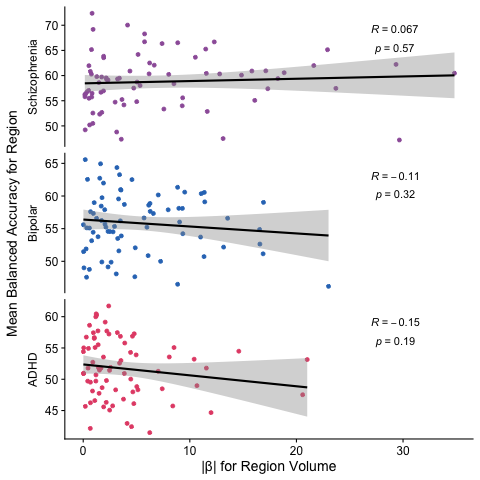

In [105]:
%%R -i ROI_voxel_counts,aparc_aseg_LUT,UCLA_CNP_brain_region_info,study_group_df,UCLA_CNP_metadata,intra_regional_p_values -o region_wise_volumes,ROI_volume_beta_by_group,run_lm_beta_stats_for_group
# Visualizations

# Read in region-wise volumes
region_wise_volumes <- ROI_voxel_counts %>%
  left_join(., UCLA_CNP_metadata, by = join_by(Sample_ID)) %>%
  left_join(., aparc_aseg_LUT, by = join_by(ROI_Index)) %>%
  left_join(., UCLA_CNP_brain_region_info, by = join_by(Brain_Region)) %>%
  filter(!is.na(Index))

# Fit OLS models to extract beta coefficient for regional volumes in each group relative to control
run_lm_beta_stats_for_group <- function(comparison_group, region_wise_volumes){
  res <- region_wise_volumes %>%
    filter(Diagnosis %in% c(comparison_group, "Control")) %>%
    dplyr::select(Brain_Region, Diagnosis, Num_Voxels) %>%
    mutate(Diagnosis = factor(Diagnosis, levels = c("Control", comparison_group))) %>%
    group_by(Brain_Region) %>%
    nest() %>%
    mutate(
      fit = map(data, ~ lm(Num_Voxels ~ Diagnosis, data = .x)),
      tidied = map(fit, tidy)
    ) %>% 
    unnest(tidied) %>%
    dplyr::select(-data, -fit) %>%
    ungroup() %>%
    filter(term != "(Intercept)") %>%
    mutate(Comparison_Group = comparison_group)
  
  return(res)
}

ROI_volume_beta_by_group <- 1:3 %>%
  purrr::map_df(~ run_lm_beta_stats_for_group(region_wise_volumes = region_wise_volumes,
                                          comparison_group = study_group_df$Comparison_Group[.x])) %>%
  group_by(Comparison_Group) %>%
  mutate(p_value_HolmBonferroni = p.adjust(p.value, method="holm"))

# Plot region-wise volume beta coefficients vs balanced accuracy
ROI_volume_beta_by_group %>%
  dplyr::select(Brain_Region, Comparison_Group, estimate) %>%
  dplyr::rename("beta_coef" = "estimate") %>%
  left_join(., intra_regional_p_values %>% dplyr::rename("Brain_Region" = "group_var"), 
            by = join_by(Brain_Region, Comparison_Group)) %>%
  mutate(Comparison_Group = factor(Comparison_Group, levels = c("Schizophrenia", "Bipolar", "ADHD"))) %>%
  ggplot(data=., mapping=aes(x=abs(beta_coef), y=100*Balanced_Accuracy_Across_Folds, color=Comparison_Group)) +
  geom_point() +
  facet_grid(Comparison_Group ~ ., scales="free", switch="both") +
  ylab("Mean Balanced Accuracy for Region") +
  xlab("|\u03b2| for Region Volume") +
  stat_cor(method="pearson", cor.coef.name="R", color="black", label.sep = "\n", label.x = 27) +
  stat_smooth(method="lm", color="black") +
  scale_color_manual(values=c("Schizophrenia" = "#9d60a8", 
                              "Bipolar" = "#2f77c0", 
                              "ADHD" = "#e45075")) +
  theme(legend.position = "none",
        panel.border = element_blank(),
        strip.background = element_blank(), 
        strip.placement = "outside")

`summarise()` has grouped output by 'Diagnosis'. You can override using the
`.groups` argument.
`geom_smooth()` using formula = 'y ~ x'


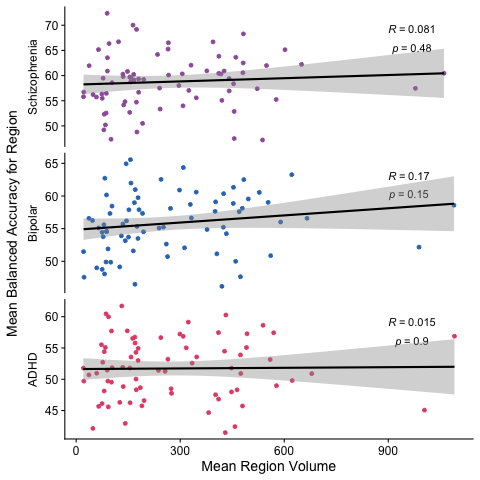

In [110]:
%%R -i region_wise_volumes,intra_regional_p_values

# Does the average volume of a region relate to its balanced accuracy?
region_wise_volumes %>%
  group_by(Diagnosis, Brain_Region) %>%
  summarise(mean_volume = mean(Num_Voxels)) %>%
  filter(Diagnosis != "Control") %>%
  dplyr::rename("Comparison_Group"="Diagnosis") %>%
  left_join(., intra_regional_p_values %>% dplyr::rename("Brain_Region" = "group_var"), by = join_by(Comparison_Group, Brain_Region)) %>%
  mutate(Comparison_Group = factor(Comparison_Group, levels = c("Schizophrenia", "Bipolar", "ADHD"))) %>%
  ggplot(data=., mapping=aes(x=mean_volume, y=100*Balanced_Accuracy_Across_Folds, color=Comparison_Group)) +
  geom_point() +
  facet_grid(Comparison_Group ~ ., scales="free", switch="both") +
  ylab("Mean Balanced Accuracy for Region") +
  xlab("Mean Region Volume") +
  stat_cor(color="black", label.sep = "\n", label.x = 900) +
  stat_smooth(method="lm", color="black") +
  scale_color_manual(values=c("Schizophrenia" = "#9d60a8", 
                            "Bipolar" = "#2f77c0", 
                            "ADHD" = "#e45075")) +
  theme(legend.position = "none",
        panel.border = element_blank(),
        strip.background = element_blank(),
        strip.placement = "outside")

# Figure S2: Comparing classification performance with versus without inverse probability weighting.

`summarise()` has grouped output by 'Comparison_Group', 'Analysis_Type',
'group_var'. You can override using the `.groups` argument.


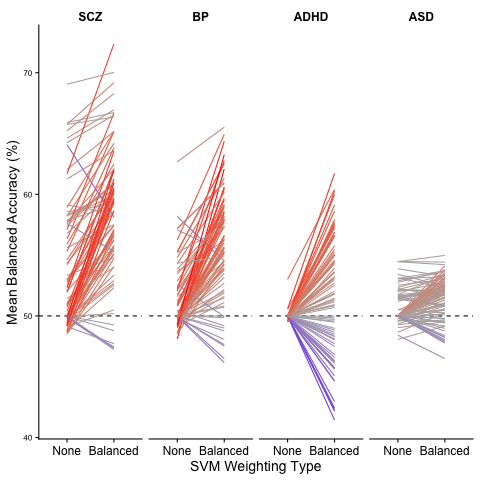

In [111]:
%%R -i balanced_accuracy_with_vs_without_inv_prob_weighting

# For each brain region, compare the difference in mean balanced accuracy with versus without inverse probability weighting
balanced_accuracy_with_vs_without_inv_prob_weighting %>%
  filter(Analysis_Type=="Brain_Region") %>%
  mutate(Comparison_Group = case_when(Comparison_Group=="Schizophrenia" ~ "SCZ",
                                      Comparison_Group=="Bipolar" ~ "BP",
                                      T ~ Comparison_Group)) %>%
  mutate(Comparison_Group = factor(Comparison_Group, levels = c("SCZ", "BP", "ADHD", "ASD")),
         Weighting_Type = factor(Weighting_Type, levels=c("None", "Balanced"))) %>%
  group_by(Comparison_Group, Analysis_Type, group_var, Weighting_Type) %>%
  summarise(Mean_Balanced_Accuracy = mean(Balanced_Accuracy)) %>%
  group_by(Comparison_Group, Analysis_Type, group_var) %>%
  mutate(Weighting_Diff = Mean_Balanced_Accuracy[Weighting_Type=="Balanced"] - Mean_Balanced_Accuracy[Weighting_Type=="None"]) %>%
  ungroup() %>%
  ggplot(data=., mapping=aes(x=Weighting_Type, y=100*Mean_Balanced_Accuracy, group=group_var, color=Weighting_Diff)) +
  geom_hline(yintercept = 50, linetype=2) +
  geom_line() +
  xlab("SVM Weighting Type") +
  ylab("Mean Balanced Accuracy (%)") +
  scale_color_gradient2(low="blue", mid="gray70", high="red", midpoint = 0) +
  facet_grid(. ~ Comparison_Group, scales="free", space="free") +
  theme(legend.position = "none",
        axis.text.y = element_text(size=8),
        strip.text.x = element_text(angle=0, face="bold"),
        strip.background = element_blank())

`summarise()` has grouped output by 'Comparison_Group', 'Analysis_Type',
'group_var'. You can override using the `.groups` argument.


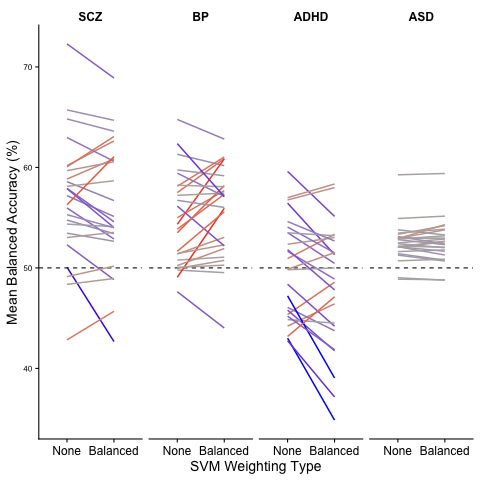

In [112]:
%%R -i balanced_accuracy_with_vs_without_inv_prob_weighting

# For each time-series feature, compare the difference in mean balanced accuracy with versus without inverse probability weighting
balanced_accuracy_with_vs_without_inv_prob_weighting %>%
  filter(Analysis_Type=="TS_Feature") %>%
  mutate(Comparison_Group = case_when(Comparison_Group=="Schizophrenia" ~ "SCZ",
                                      Comparison_Group=="Bipolar" ~ "BP",
                                      T ~ Comparison_Group)) %>%
  mutate(Comparison_Group = factor(Comparison_Group, levels = c("SCZ", "BP", "ADHD", "ASD")),
         Weighting_Type = factor(Weighting_Type, levels=c("None", "Balanced"))) %>%
  group_by(Comparison_Group, Analysis_Type, group_var, Weighting_Type) %>%
  summarise(Mean_Balanced_Accuracy = mean(Balanced_Accuracy)) %>%
  group_by(Comparison_Group, Analysis_Type, group_var) %>%
  mutate(Weighting_Diff = Mean_Balanced_Accuracy[Weighting_Type=="Balanced"] - Mean_Balanced_Accuracy[Weighting_Type=="None"]) %>%
  ungroup() %>%
  ggplot(data=., mapping=aes(x=Weighting_Type, y=100*Mean_Balanced_Accuracy, group=group_var, color=Weighting_Diff)) +
  geom_hline(yintercept = 50, linetype=2) +
  geom_line(linewidth=0.7) +
  xlab("SVM Weighting Type") +
  ylab("Mean Balanced Accuracy (%)") +
  scale_color_gradient2(low="blue", mid="gray70", high="red", midpoint = 0) +
  facet_grid(. ~ Comparison_Group, scales="free", space="free") +
  theme(legend.position = "none",
        axis.text.y = element_text(size=8),
        strip.text.x = element_text(angle=0, face="bold"),
        strip.background = element_blank())

# Figure S3. Evaluating dimensionality reduction for univariate region $\times$ feature combination classifiers ($\mathrm{A_{uni\_combo}}$)

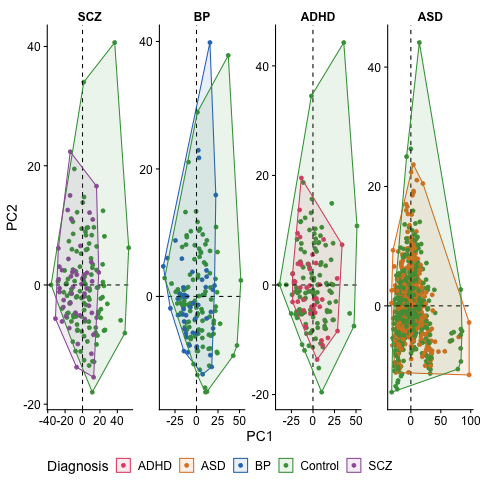

In [115]:
%%R -i UCLA_CNP_intra_regional_feature_data,ABIDE_ASD_intra_regional_feature_data,study_group_df,univariate_TS_feature_info -o pca_scores

# PCA with the first 25 PCs
pca_scores_list <- list()

for (i in 1:nrow(study_group_df)) {
  dataset_ID <- study_group_df$Study[i]
  comparison_group <- study_group_df$Comparison_Group[i]
  group_nickname <- study_group_df$Group_Nickname
  
  if (dataset_ID == "UCLA_CNP") {
    input_data = UCLA_CNP_intra_regional_feature_data
  } else {
    input_data = ABIDE_ASD_intra_regional_feature_data
  }
  
  # Prep data for PCA
  data_for_PCA <- input_data %>%
    filter(Diagnosis %in% c("Control", comparison_group)) %>%
    left_join(., univariate_TS_feature_info, by=c("names"="feature_name")) %>%
    mutate(unique_ID = paste0(Figure_name, "__", Brain_Region), .keep="unused") %>%
    dplyr::select(unique_ID, Sample_ID, Diagnosis, values) %>%
    pivot_wider(id_cols=c(Sample_ID, Diagnosis), names_from=unique_ID, values_from=values) %>%
    mutate(Diagnosis=factor(Diagnosis, levels=c("Control", comparison_group)))
  
  # Compute PCA
  pca_res <- PCA(select(data_for_PCA, c(-Sample_ID, -Diagnosis)), ncp=25, graph = FALSE, scale.unit = TRUE)
  pca_scores <- as.data.frame(pca_res$ind$coord) %>%
    mutate(Sample_ID = data_for_PCA$Sample_ID,
           Diagnosis = data_for_PCA$Diagnosis,
           Comparison_Group = comparison_group,
           Study = dataset_ID)
  
  pca_scores_list <- list.append(pca_scores_list, pca_scores)
}

pca_scores <- do.call(plyr::rbind.fill, pca_scores_list)

pca_scores %>%
  mutate(Diagnosis = case_when(Diagnosis == "Schizophrenia" ~ "SCZ",
                               Diagnosis == "Bipolar" ~ "BP",
                               T ~ Diagnosis),
         Comparison_Group = case_when(Comparison_Group == "Schizophrenia" ~ "SCZ",
                                      Comparison_Group == "Bipolar" ~ "BP",
                                      T ~ Comparison_Group)) %>%
  mutate(Comparison_Group = factor(Comparison_Group, levels = c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ggplot(data=., mapping=aes(x=`Dim.1`, y=`Dim.2`, color=Diagnosis)) +
  geom_point() +
  geom_vline(xintercept = 0, linetype=2) +
  geom_hline(yintercept = 0, linetype=2) +
  stat_chull(aes(color = Diagnosis, fill = Diagnosis), 
             alpha = 0.1, geom = "polygon")+
  ylab("PC2") +
  xlab("PC1") +
  facet_wrap(Comparison_Group ~ ., scales="free", nrow=1) +
  scale_fill_manual(values = c("SCZ"="#9d60a8", 
                                "BP"="#2F77C0", 
                                "ADHD"="#e45075",
                                "ASD" = "#E28328",
                                "Control" = "#439E47")) +
  scale_color_manual(values = c("SCZ"="#9d60a8", 
                                "BP"="#2F77C0", 
                                "ADHD"="#e45075",
                                "ASD" = "#E28328",
                                "Control" = "#439E47")) +
  theme(legend.position = "bottom",
        strip.text = element_text(face="bold"),
        strip.background = element_blank())

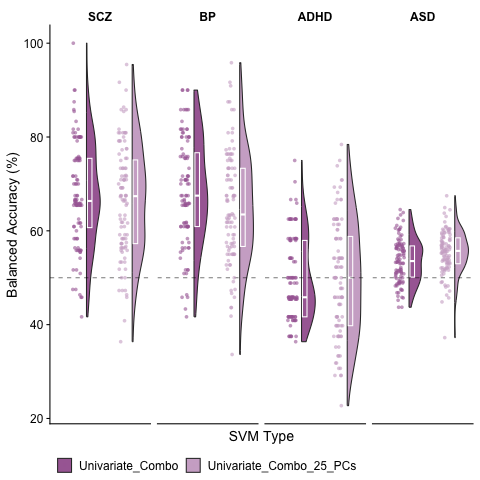

In [118]:
%%R -i intra_regional_uni_combo_first25_PCs_balanced_accuracy,intra_regional_balanced_accuracy_all_folds,study_group_df
# Comparing classification performance using the first 25 PCs per disorder

intra_regional_uni_combo_first25_PCs_balanced_accuracy %>%
  plyr::rbind.fill(intra_regional_balanced_accuracy_all_folds %>% filter(Analysis_Type=="Univariate_Combo")) %>%
  left_join(study_group_df, by = join_by(Study, Comparison_Group)) %>%
  mutate(Group_Nickname = factor(Group_Nickname, levels=c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ggplot(data=., mapping=aes(x=Analysis_Type, y=100*Balanced_Accuracy)) +
  xlab("SVM Type") +
  ylab("Balanced Accuracy (%)") +
  geom_violinhalf(aes(fill = Analysis_Type), 
                  position = position_nudge(x=0.2),
                  scale="width", width=0.6)  +
  geom_boxplot(width=0.1, notch=FALSE, notchwidth = 0.4, outlier.shape = NA,
               fill=NA, color="white",
               position = position_nudge(x=0.27), coef = 0) +
  geom_hline(yintercept = 50, linetype=2, alpha=0.5) +
  facet_grid(. ~ Group_Nickname) +
  geom_point(aes(color = Analysis_Type), position = position_jitter(width=0.1),
             size = 1.75, alpha=0.6, stroke=0) +
  labs(fill="", color="") +
  scale_fill_manual(values = c("#a86ba3", "#cfafcd")) +
  scale_color_manual(values = c("#a86ba3", "#cfafcd")) +
  theme(legend.position = "bottom",
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        strip.text = element_text(face="bold"),
        strip.background = element_blank())

`summarise()` has grouped output by 'Study', 'Comparison_Group'. You can
override using the `.groups` argument.


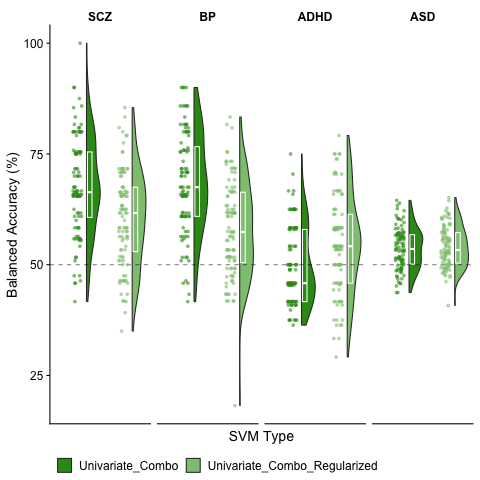

In [119]:
%%R -i SVM_L1_balanced_accuracy_by_folds,study_group_df,intra_regional_balanced_accuracy_all_folds

# L1-regularized SVM comparison

# Aggregate balanced accuracy by repeats
SVM_L1_balanced_accuracy <- SVM_L1_balanced_accuracy_by_folds %>%
  group_by(Study, Comparison_Group, Analysis_Type) %>%
  summarise(Balanced_Accuracy_Across_Folds = mean(Balanced_Accuracy, na.rm=T),
            Balanced_Accuracy_Across_Folds_SD = sd(Balanced_Accuracy, na.rm=T)) 

# Plot performance in normal SVM vs. L1-regularized SVM
SVM_L1_balanced_accuracy_by_folds %>%
  plyr::rbind.fill(intra_regional_balanced_accuracy_all_folds %>% filter(Analysis_Type=="Univariate_Combo")) %>%
  left_join(study_group_df, by = join_by(Study, Comparison_Group)) %>%
  mutate(Group_Nickname = factor(Group_Nickname, levels=c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ggplot(data=., mapping=aes(x=Analysis_Type, y=100*Balanced_Accuracy)) +
  xlab("SVM Type") +
  ylab("Balanced Accuracy (%)") +
  geom_violinhalf(aes(fill = Analysis_Type), 
                  position = position_nudge(x=0.2),
                  scale="width", width=0.6)  +
  geom_boxplot(width=0.1, notch=FALSE, notchwidth = 0.4, outlier.shape = NA,
               fill=NA, color="white",
               position = position_nudge(x=0.27), coef = 0) +
  geom_hline(yintercept = 50, linetype=2, alpha=0.5) +
  facet_grid(. ~ Group_Nickname) +
  geom_point(aes(color = Analysis_Type), position = position_jitter(width=0.1),
             size = 1.75, alpha=0.6, stroke=0) +
  labs(fill="", color="") +
  scale_fill_manual(values = c("#319719", "#8dc57f")) +
  scale_color_manual(values = c("#319719", "#8dc57f")) +
  theme(legend.position = "bottom",
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        strip.text = element_text(face="bold"),
        strip.background = element_blank())

# Figure S4: Most patients show greater head movement in the scanner, which can distinguish them from controls

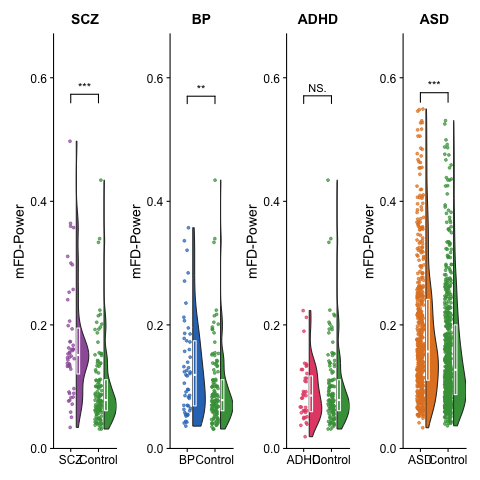

In [14]:
%%R -i UCLA_CNP_metadata,ABIDE_ASD_metadata,participants_in_project,data_path -o FD_dataset,UCLA_CNP_mean_FD,ABIDE_ASD_mean_FD

# Load head movement data
UCLA_CNP_mean_FD <- read.table("data/UCLA_CNP_mFD.txt", 
                                       sep=",", colClasses = "character")
ABIDE_ASD_mean_FD <- read.table("data/ABIDE_ASD_mFD.txt",
                                     sep=",", colClasses = "character")
colnames(UCLA_CNP_mean_FD) <- colnames(ABIDE_ASD_mean_FD) <- c("Sample_ID", "Jenkinson", "Power", "VanDijk")

# Set mFD columns as numeric
UCLA_CNP_mean_FD <- UCLA_CNP_mean_FD %>%
  mutate_at(c("Jenkinson", "Power", "VanDijk"), function(x) as.numeric(x)) %>%
  left_join(., UCLA_CNP_metadata, by="Sample_ID") %>%
  filter(Sample_ID %in% participants_in_project$Sample_ID) %>%
  mutate(Study = "UCLA_CNP")

ABIDE_ASD_mean_FD <- ABIDE_ASD_mean_FD %>%
  mutate_at(c("Jenkinson", "Power", "VanDijk"), function(x) as.numeric(x)) %>%
  left_join(., ABIDE_ASD_metadata, by = join_by(Sample_ID)) %>%
  filter(Sample_ID %in% participants_in_project$Sample_ID) %>%
  mutate(Study = "ABIDE_ASD")

control_color <- "#439E47"
group_colors <- c("#9d60a8", "#2F77C0", "#e45075","#E28328")

# Find ymin and ymax
FD_dataset = plyr::rbind.fill(UCLA_CNP_mean_FD, ABIDE_ASD_mean_FD)
ymin <- 0
ymax <- max(FD_dataset$Power)
plots <- 1:4 %>%
  purrr::map(~ plot_group_vs_control_mean_FD(FD_dataset = FD_dataset,
                                     study = study_group_df$Study[.x],
                                     dx = study_group_df$Comparison_Group[.x],
                                     dx_title = study_group_df$Group_Nickname[.x],
                                     ymin = ymin,
                                     ymax = 0.61,
                                     group_color = group_colors[.x]))

wrap_plots(plots, nrow=1)

# Figure S5: Head movement in the scanner is associated with whole-brain and regional BOLD SD in some disorders

Joining with `by = join_by(Sample_ID)`
Joining with `by = join_by(Sample_ID, Diagnosis, Age, Sex, Study, Site)`
`geom_smooth()` using formula = 'y ~ x'


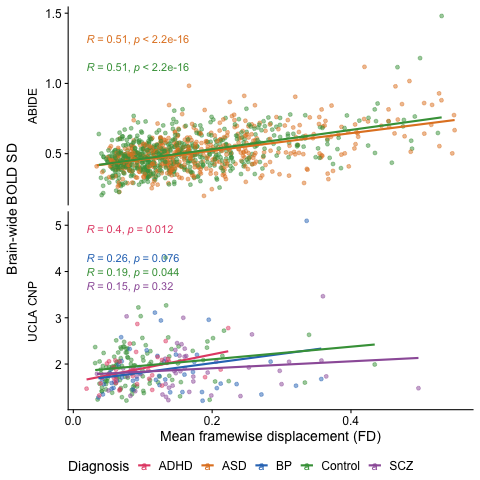

In [15]:
%%R -i UCLA_CNP_intra_regional_feature_data,ABIDE_ASD_intra_regional_feature_data,UCLA_CNP_mean_FD,ABIDE_ASD_mean_FD,UCLA_CNP_metadata,ABIDE_ASD_metadata -o SD_brain_wide_avg
# Plot brain-wide average SD vs head movement
SD_brain_wide_avg <- UCLA_CNP_intra_regional_feature_data %>%
  plyr::rbind.fill(., ABIDE_ASD_intra_regional_feature_data) %>%
  filter(names == "DN_Spread_Std") %>%
  group_by(Sample_ID) %>%
  summarise(meanval = mean(values, na.rm=T)) %>%
  left_join(., plyr::rbind.fill(UCLA_CNP_mean_FD, ABIDE_ASD_mean_FD)) %>%
  left_join(., plyr::rbind.fill(UCLA_CNP_metadata, ABIDE_ASD_metadata)) %>%
  mutate(Study = ifelse(Study == "UCLA_CNP", "UCLA CNP", "ABIDE"))  %>%
  mutate(Diagnosis = case_when(Diagnosis == "Schizophrenia" ~ "SCZ",
                               Diagnosis == "Bipolar" ~ "BP",
                               T ~ Diagnosis))

SD_brain_wide_avg %>%
  ggplot(data=., mapping=aes(x=Power, y=meanval, color=Diagnosis)) +
  geom_point(alpha=0.5) +
  facet_grid(Study ~ ., scale="free", switch="both") +
  ylab("Brain-wide BOLD SD") +
  xlab("Mean framewise displacement (FD)") +
  scale_color_manual(values = c("Control" = "#439E47", 
                                "SCZ" = "#9d60a8", 
                                "BP" = "#2F77C0", 
                                "ADHD" = "#e45075", 
                                "ASD" = "#E28328")) +
  stat_smooth(method="lm", se=F) +
  theme(strip.background = element_blank(),
        legend.position="bottom",
        strip.placement="outside") +
  stat_cor()

In [125]:
%%R -i SD_brain_wide_avg

# # Calculate correlations
SD_brain_wide_avg %>%
  group_by(Study, Diagnosis) %>%
  nest() %>%
  mutate(
    test = map(data, ~ cor.test(.x$meanval, .x$Power)), # S3 list-col
    tidied = map(test, tidy)
  ) %>%
  unnest(tidied)

# A tibble: 6 × 12
# Groups:   Study, Diagnosis [6]
  Diagnosis Study    data     test    estimate statistic  p.value parameter
  <chr>     <chr>    <list>   <list>     <dbl>     <dbl>    <dbl>     <int>
1 Control   ABIDE    <tibble> <htest>    0.508     14.1  3.34e-39       576
2 ASD       ABIDE    <tibble> <htest>    0.508     13.3  4.98e-35       511
3 Control   UCLA CNP <tibble> <htest>    0.187      2.03 4.44e- 2       114
4 SCZ       UCLA CNP <tibble> <htest>    0.148      1.01 3.16e- 1        46
5 BP        UCLA CNP <tibble> <htest>    0.255      1.81 7.65e- 2        47
6 ADHD      UCLA CNP <tibble> <htest>    0.399      2.65 1.18e- 2        37
# ℹ 4 more variables: conf.low <dbl>, conf.high <dbl>, method <chr>,
#   alternative <chr>


Joining with `by = join_by(Sample_ID, Diagnosis, Age, Sex, Study, Site)`
Joining with `by = join_by(Sample_ID, Diagnosis, Age, Sex, Study, Site)`


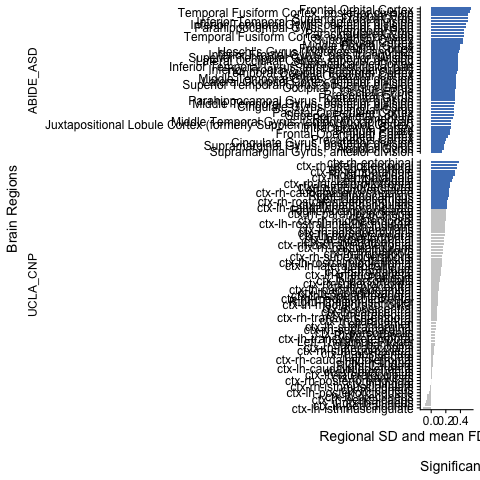

In [16]:
%%R -i UCLA_CNP_intra_regional_feature_data,ABIDE_ASD_intra_regional_feature_data,UCLA_CNP_metadata,ABIDE_ASD_metadata,UCLA_CNP_mean_FD,ABIDE_ASD_mean_FD -o head_motion_SD_corr_regional

# Compare region-specific SD values with whole-brain head movement

# Calculate correlations
head_motion_SD_corr_regional <- UCLA_CNP_intra_regional_feature_data %>%
  plyr::rbind.fill(., ABIDE_ASD_intra_regional_feature_data) %>%
  filter(names == "DN_Spread_Std") %>%
  left_join(., plyr::rbind.fill(UCLA_CNP_mean_FD, ABIDE_ASD_mean_FD)) %>%
  left_join(., plyr::rbind.fill(UCLA_CNP_metadata, ABIDE_ASD_metadata)) %>%
  group_by(Study, Brain_Region) %>%
  nest() %>%
  mutate(
    test = map(data, ~ cor.test(.x$values, .x$Power)), # S3 list-col
    tidied = map(test, tidy)
  ) %>%
  unnest(tidied) %>%
  select(-data, -test) %>%
  group_by(Study) %>%
  mutate(p_HolmBonferroni = p.adjust(p.value, method="holm")) %>%
  arrange(desc(abs(estimate)))

# Plot regional SD correlations by brain region within the brain
head_motion_SD_corr_regional %>%
  mutate(Brain_Region = fct_reorder(Brain_Region, estimate)) %>%
  ggplot(data=., mapping=aes(x=Brain_Region,
                             y=estimate,
                             fill=p_HolmBonferroni<0.05)) +
  geom_bar(stat="identity") +
  facet_grid(Study ~ ., scales="free", switch="both",
             space="free") +
  coord_flip() +
  scale_fill_manual(values=list("TRUE"="#4C7FC0",
                                "FALSE"="gray80")) +
  labs(fill = "Significant") +
  xlab("Brain Regions") +
  ylab("Regional SD and mean FD correlation, R") +
  theme(strip.background = element_blank(),
        legend.position="bottom",
        strip.placement="outside")

# Figure S6: Null balanced accuracy metrics are approximately normally distributed across brain regions in all clinical cohorts.

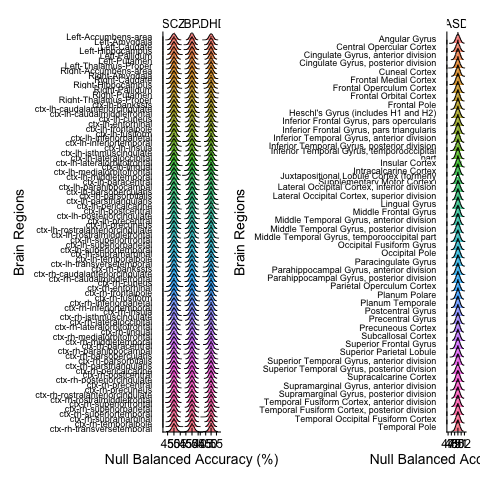

In [132]:
%%R -i intra_regional_nulls,study_group_df

intra_regional_nulls_brain_regions <- intra_regional_nulls %>% filter(Analysis_Type == "Univariate_Brain_Region") %>%
  mutate(Null_Balanced_Accuracy = 100*Null_Balanced_Accuracy) %>%
  group_by(Analysis_Type, Comparison_Group, Study, group_var) %>%
  mutate(mu = mean(Null_Balanced_Accuracy),
         sigma = sd(Null_Balanced_Accuracy))

# Plot in one ridgeline plot
UCLA_CNP_summary_curves <- intra_regional_nulls_brain_regions %>%
  filter(Study=="UCLA_CNP") %>%
  left_join(., study_group_df, by = join_by(Comparison_Group, Study)) %>%
  group_by(group_var, Group_Nickname) %>%
  mutate(Group_Nickname = factor(Group_Nickname, levels=c("SCZ", "BP", "ADHD"))) %>%
  reframe(x = Null_Balanced_Accuracy,
          y = dnorm(Null_Balanced_Accuracy, 
                    mean = mean(Null_Balanced_Accuracy),
                    sd = sd(Null_Balanced_Accuracy)))

UCLA_CNP_univariate_null_plot <- intra_regional_nulls_brain_regions %>%
  left_join(., study_group_df, by = join_by(Comparison_Group, Study)) %>%
  filter(Study=="UCLA_CNP") %>%
  mutate(Group_Nickname = factor(Group_Nickname, levels=c("SCZ", "BP", "ADHD"))) %>%
  ggplot(data=., mapping=aes(fill = group_var, x=Null_Balanced_Accuracy)) +
  geom_histogram(aes(y = after_stat(density)), alpha=0.7, bins=30) +
  facet_grid(group_var~Group_Nickname, scales="free", switch="y") +
  xlab("Null Balanced Accuracy (%)") +
  ylab("Brain Regions") +
  geom_line(data=UCLA_CNP_summary_curves, aes(x=x, y=y), color="black") +
  geom_vline(xintercept = 50, linetype=2) +
  theme(legend.position="none",
        strip.text.y.left = element_text(angle=0, size=9, lineheight = 0.6, hjust=1),
        strip.background = element_blank(),
        strip.placement="outside",
        panel.spacing = unit(-0.25, "lines"),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank()) 

# Calculate the normal curve density for each group
ABIDE_summary_curves <- intra_regional_nulls_brain_regions %>%
  filter(Study=="ABIDE_ASD") %>%
  left_join(., study_group_df, by = join_by(Comparison_Group, Study)) %>%
  group_by(group_var) %>%
  reframe(x = Null_Balanced_Accuracy,
          y = dnorm(Null_Balanced_Accuracy, 
                    mean = mean(Null_Balanced_Accuracy),
                    sd = sd(Null_Balanced_Accuracy)))

ABIDE_univariate_null_plot <- intra_regional_nulls_brain_regions %>%
  filter(Study=="ABIDE_ASD") %>%
  left_join(., study_group_df, by = join_by(Comparison_Group, Study)) %>%
  ggplot(data=., mapping=aes(fill = group_var, x=Null_Balanced_Accuracy)) +
  geom_histogram(aes(y = after_stat(density)), alpha=0.7, bins=30) +
  facet_grid(group_var~Group_Nickname, scales="free", switch="y",
             labeller = labeller(group_var = label_wrap_gen(45))) +
  xlab("Null Balanced Accuracy (%)") +
  ylab("Brain Regions") +
  geom_line(data=ABIDE_summary_curves, aes(x=x, y=y), color="black") +
  geom_vline(xintercept = 50, linetype=2) +
  theme(legend.position="none",
        strip.text.y.left = element_text(angle=0, size=9, lineheight = 0.6, hjust=1),
        strip.background = element_blank(),
        strip.placement="outside",
        panel.spacing = unit(-0.25, "lines"),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank()) 

wrap_plots(list(UCLA_CNP_univariate_null_plot, ABIDE_univariate_null_plot), widths = c(0.75, 0.25))


# Figure S7: Participants are allocated into the same set of folds and repeats across models to enable direct comparison of performance across models

In [134]:
%%R -i intra_regional_fold_assignments

intra_regional_fold_assignments %>%
  left_join(., plyr::rbind.fill(UCLA_CNP_metadata, ABIDE_ASD_metadata), by = join_by(Sample_ID, Study)) %>%
  group_by(Comparison_Group, Study) %>%
  mutate(num_samples = length(unique(Sample_ID))) %>%
  group_by(Study, Comparison_Group, group_var, Repeat) %>%
  mutate(Control_Prop = 100*sum(Diagnosis == "Control")/num_samples) %>%
  group_by(Study, Comparison_Group, group_var, Fold, Repeat, Control_Prop) %>%
  summarise(num_subjects_in_test_fold = n(),
         num_controls_in_test_fold = sum(Diagnosis == "Control"),
         control_prop_in_fold = 100*num_controls_in_test_fold/num_subjects_in_test_fold) %>%
  group_by(Study, Comparison_Group, Control_Prop) %>%
  summarise(mean_control_prop_across_folds = mean(control_prop_in_fold),
            min_control_prop_across_folds = min(control_prop_in_fold),
            max_control_prop_across_folds = max(control_prop_in_fold),
            SD_control_prop_across_folds = sd(control_prop_in_fold))


`summarise()` has grouped output by 'Study', 'Comparison_Group', 'group_var',
'Fold', 'Repeat'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Study', 'Comparison_Group'. You can
override using the `.groups` argument.
# A tibble: 4 × 7
# Groups:   Study, Comparison_Group [4]
  Study     Comparison_Group Control_Prop mean_control_prop_across_folds
  <chr>     <chr>                   <dbl>                          <dbl>
1 ABIDE_ASD ASD                      53.0                           53.0
2 UCLA_CNP  ADHD                     74.8                           74.8
3 UCLA_CNP  Bipolar                  70.3                           70.3
4 UCLA_CNP  Schizophrenia            70.7                           70.7
# ℹ 3 more variables: min_control_prop_across_folds <dbl>,
#   max_control_prop_across_folds <dbl>, SD_control_prop_across_folds <dbl>


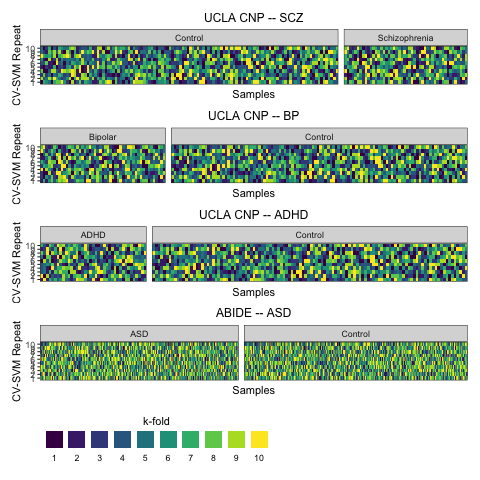

In [135]:
%%R -i intra_regional_fold_assignments,UCLA_CNP_metadata,ABIDE_ASD_metadata

# UCLA CNP schizophrenia vs. control ctx-lh-caudalanteriorcingulate
UCLA_scz_heatmap <- intra_regional_fold_assignments %>%
  filter(Study == "UCLA_CNP", Comparison_Group  == "Schizophrenia") %>%
  left_join(., UCLA_CNP_metadata, by = join_by(Sample_ID, Study)) %>%
  plot_fold_heatmap_for_dataset(fold_assignments_df = .,
                           group_var_to_use = "ctx-lh-caudalanteriorcingulate",
                           plot_title = "UCLA CNP -- SCZ")


# UCLA CNP ADHD vs. control ctx-lh-caudalanteriorcingulate
UCLA_ADHD_heatmap <- intra_regional_fold_assignments %>%
  filter(Study == "UCLA_CNP", Comparison_Group  == "ADHD") %>%
  left_join(., UCLA_CNP_metadata, by = join_by(Sample_ID, Study)) %>%
  plot_fold_heatmap_for_dataset(fold_assignments_df = .,
                           group_var_to_use = "ctx-lh-caudalanteriorcingulate",
                           plot_title = "UCLA CNP -- ADHD")


# UCLA CNP ADHD vs. control ctx-lh-caudalanteriorcingulate
UCLA_bipolar_heatmap <- intra_regional_fold_assignments %>%
  filter(Study == "UCLA_CNP", Comparison_Group  == "Bipolar") %>%
  left_join(., UCLA_CNP_metadata, by = join_by(Sample_ID, Study)) %>%
  plot_fold_heatmap_for_dataset(fold_assignments_df = .,
                           group_var_to_use = "ctx-lh-caudalanteriorcingulate",
                           plot_title = "UCLA CNP -- BP")


# Use ABIDE ASD vs. control Superior Frontal Gyrus as example
ABIDE_ASD_heatmap <- intra_regional_fold_assignments %>%
  filter(Study == "ABIDE_ASD", Comparison_Group  == "ASD") %>%
  left_join(., ABIDE_ASD_metadata, by = join_by(Sample_ID, Study)) %>%
  plot_fold_heatmap_for_dataset(fold_assignments_df = .,
                           group_var_to_use = "Superior Frontal Gyrus",
                           plot_title = "ABIDE -- ASD")

wrap_plots(list(UCLA_scz_heatmap,
                UCLA_bipolar_heatmap,
                UCLA_ADHD_heatmap,
                ABIDE_ASD_heatmap),
           ncol = 1) + 
  plot_layout(guides = "collect") & theme(legend.position = 'bottom',
                                          plot.title = element_text(size=12))

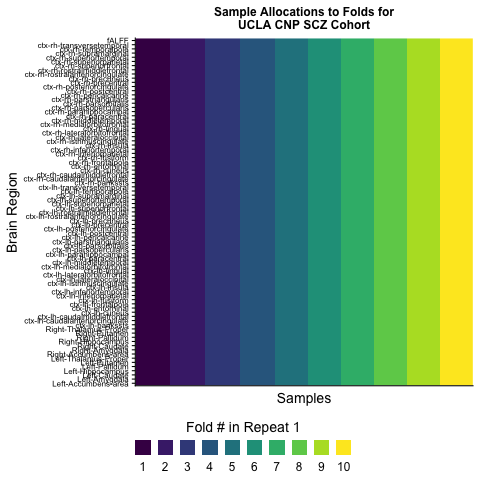

In [136]:
%%R -i intra_regional_fold_assignments

# Heatmap for all 82 brain regions in the UCLA schizophrenia vs control dataset 
# to show that samples are allocated in the same way across regions within repeat 1

intra_regional_fold_assignments %>%
  filter(Study == "UCLA_CNP", Comparison_Group == "Schizophrenia",
         Analysis_Type == "Brain_Region", Repeat == 1) %>%
  mutate(Fold = factor(Fold)) %>%
  ggplot(data = ., mapping = aes(x=fct_reorder(Sample_ID, as.numeric(Fold)), y = group_var, fill = Fold)) +
  geom_raster() +
  scale_fill_viridis_d() +
  ylab("Brain Region") +
  labs(fill = "Fold # in Repeat 1") +
  ggtitle("Sample Allocations to Folds for\nUCLA CNP SCZ Cohort") +
  xlab("Samples") +
  theme(legend.position="bottom",
        plot.title = element_text(hjust=0.5, size=12),
        axis.text.y = element_text(size=8),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank()) +
  guides(fill = guide_legend(title.position = "top", 
                             nrow = 1,
                             title.hjust = 0.5,
                             label.position = "bottom")) 

# Figure S8: Comparing normalization methods supports the use of the outlier-robust mixed sigmoid method

In [5]:
normalization_binned_data = pd.read_feather("data/all_normalisations_counts.feather")